# Test using actual GLM data

Like the test in Coordinate graph.ipynb, but adapted to use actual GLM data.

In [1]:
import glob
from datetime import datetime

%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr
from glmtools.io.ccd import load_pixel_corner_lookup, quads_from_corner_lookup
from glmtools.io.glm import GLMDataset
from glmtools.grid.clipping import QuadMeshSubset, QuadMeshPolySlicer
from glmtools.grid.split_events import split_event_data, split_event_dataset_from_props, replicate_and_weight_split_event_dataset

In [2]:
lon_lut, lat_lut, corner_lut = load_pixel_corner_lookup('/data/LCFA-production/L1b/G16_corner_lut.pickle')

In [3]:
glm_files = glob.glob('/data/GOES16harvey/OR_GLM*.nc')
glm = GLMDataset(glm_files[0])
nadir_lon = glm.dataset.number_of_events.lon_field_of_view.data
print("Satellite is above {0} degrees longitude".format(nadir_lon))

Satellite is above -89.5 degrees longitude


In [4]:
# define a regular lat/lon grid. dlat of 0.01 is about 1 km resolution 
lonmin, lonmax = -105, -85
latmin, latmax = 18, 32
x = np.arange(lonmin, lonmax, 0.05)
y = np.arange(latmin, latmax, 0.05)
X,Y=np.meshgrid(x,y)
vals = np.random.rand(X.shape[0]-1, X.shape[1]-1)

# The expensive step
mesh = QuadMeshSubset(X, Y, n_neighbors=16)

print(datetime.now())

Calculating polygons from mesh ...
    ... constructing search tree ... be patient ...
    ... done.
2018-01-16 05:48:24.796838


In [5]:
# We assume here that that the data are regularly gridded, 
# so that a single row or column are representative of the lons, lats
# along each dimension
# event_lons = glm.dataset.event_lon[:].data
# event_lats = glm.dataset.event_lat[:].data
# event_rads = glm.dataset.event_energy[:].data
# good = (event_lons > lonmin) & (event_lons < lonmax) & (event_lats > latmin) & (event_lats < latmax)
# subset_events = glm.dataset[{'number_of_events':good}]

glm_data = glm.subset_flashes(lon_range=(lonmin,lonmax),
                              lat_range=(latmin,latmax))

event_lons = glm_data.event_lon.data
event_lats = glm_data.event_lat.data
event_rads = glm_data.event_energy.data
event_ids = glm_data.event_id.data

# event_rads = np.log10(event_rads[good])
# rad_min, rad_max = event_rads.min(), event_rads.max()
# event_rads = event_rads[good]
# event_ids = glm.dataset.event_ids[good].data
rad_min, rad_max = 1e-16, .2e-13*5

event_polys = quads_from_corner_lookup(lon_lut[0,:], lat_lut[:,0], corner_lut, event_lons, event_lats, nadir_lon=nadir_lon)
print(event_polys.shape)

(1499, 4, 2)


In [6]:
# For adding up radiance values in any pixel, use the fractional area of the event


# def gen_split_events(chopped_polys, event_ids=None):
#     """
#     chopped_polys is a list of N polygons whose elements contain the sub-polys of each polygon.
#         It is the data structure created by QuadMeshPolySlicer.slice
#     event_ids are N corresponding event_ids
#     """
#     if event_ids is None: event_ids = range(len(chopped_polys))
    
#     for (subquads, frac_areas, (x_idxs, y_idxs)), total_area, evid in zip(chopped_polys, poly_areas, event_ids):
#         quad_fracs = slicer.quad_frac_from_poly_frac_area(
#                         frac_areas, total_area, x_idxs, y_idxs)

#         for subquad, frac_area, x_idx, y_idx, quad_area in zip(subquads, frac_areas, x_idxs, y_idxs, quad_fracs):
# #             print('-------')
# #             print('subquad', subquad)
# #             print('frac_area, quad_frac_area', frac_area, quad_area)
# #             print('evid, idx', evid, x_idx, y_idx)
#             yield (subquad, frac_area, quad_area, (x_idx, y_idx), evid)

# def split_event_dataset(split_polys, event_ids):
#     """
#     split_polys is a list of N polygons whose elements contain the sub-polys of each polygon.
#         It is the data structure created by QuadMeshPolySlicer.slice
#     event_ids are N corresponding event_ids
#     """

#     # fromiter would run faster if we could precalculate the count, though
#     # doing so would require iterating to sum some sizes, so it's not clear
#     # if there's much net benefit.
#     dtype = np.dtype([
# #         ('poly','f8',(4,2)), # polys could be any number of verts, so don't use.
#         ('poly_ctr', 'f8', (2,)),
#         ('event_frac_area', 'f8'),
#         ('mesh_frac_area', 'f8'),
#         ('mesh_idx', 'i8', (2,)),
# #         ('mesh_y_idx', 'i8'),
#         ('event_id', 'u8')
#     ])
    
#     parts_of_split_polys = [p for p in gen_split_events(split_polys, event_ids)]
    
#     # Each element here will be an (n_verts, 2) array of polygon vertex locations.
#     sub_polys = [np.asarray(sp[0],dtype='f8') for sp in parts_of_split_polys]

#     # These are frac_area, quad_area, (x_idx, y_idx), evid - i.e., 
#     # the parts with the same length that can be turned into an array.
#     split_event_property_iter = (sp[1:] for sp in parts_of_split_polys)
    
#     n_sub_polys = len(sub_polys)
    
# #     for sp, (frac_area, quad_area, idxs, evid) in zip(sub_polys, split_event_property_iter):
# #         sp.mean(axis=0)
    
#     split_event_iter = ((sp.mean(axis=0), frac_area, quad_area, idxs, evid)
#                         for (sp, (frac_area, quad_area, idxs, evid)) in 
#                         zip(sub_polys, split_event_property_iter))
    
#     d = np.fromiter(split_event_iter, dtype=dtype, count=n_sub_polys)

#     return sub_polys, d
    

def gen_polys(chopped_polys):
    # After getting the flash_data in io.read_flashes, pass the glm dataset 
    # to a function that does the polygon buisness. Will also need the grid spec.
    # Then do below.

    # dimension['number_of_split_events']  = n_chopped_polys # resulting from the iterator
    # Along that dimension need varaibles split_event_lat, split_event_lon, split_event_flash_id, 
    # split_event_parent_event_id, split_event_time_offset, split_event_energy
    
    # subquad_ctrs = subquad.mean(axis=) # along dimension with size 4.
    # split_event_lon = subquad_ctrs[:,:,0],
    # split_event_lat = subquad_ctrs[:,:,1],
    # split_event_parent_event_id = event_id (from iterator)
    # split_event_parent_group_id = event_parent_group_id (from iterator)
    # split_event_parent_flash_id = event_parent_flash_id (from iterator)
    # split_event_time_offset = area*event_rads (from iterator)
    # split_event_energy = event_time_offset (from iterator)
    
    # Also need to calculate split_event_count
    
    # The above is a replication operation, so maybe we could use the traversal class to create
    # the necessary variables after replicating the IDs only. But I think if we replicate the IDs,
    # which are part of the index, we can use the event_id column (which contains the replicated ids)
    # replicate any variable by indexing with event_id.
    
    # 
    
    # This loops over the original events
    # Generate a bunch of new events from the original events by weighting the original events
    # by their areas. To link back to the original data, retain the event_id. A
    # event_id, lon, lat, 
#         event_dtype=[('flash_id', '<i4'), 
#                  ('alt', '<f4'), 
# #                  ('charge', 'i1'), ('chi2', '<f4'), ('mask', 'S4'), ('stations', 'u1'),
#                  ('lat', '<f4'), ('lon', '<f4'), ('time', '<f8'),
#                  ('power', '<f4'), ]

    
    for (subquads, areas, (x_idxs, y_idxs)), total_area, val in zip(chopped_polys, poly_areas, poly_vals):
        quad_fracs = slicer.quad_frac_from_poly_frac_area(
                        areas, total_area, x_idxs, y_idxs)

        for subquad, area, x_idx, y_idx, quad_area in zip(subquads, areas, x_idxs, y_idxs, quad_fracs):
            print('-------')
            print('subquad', subquad)
            print('frac_area, quad_frac_area', area, quad_area)
            print('idx', x_idx, y_idx)
            yield (subquad, area, (x_idx, y_idx), val*area)
        
# good_polys = [p for p in gen_polys(chopped_polys)]

# good_polys = get_glm_split_events(chopped_polys, event_ids)



    
# #     d = {'coords': {'t': {'dims': 't', 'data': t,
# #                       'attrs': {'units':'s'}}},
# #      'attrs': {'title': 'air temperature'},
# #      'dims': 't',
# #      'data_vars': {'a': {'dims': 't', 'data': x, },
# #                    'b': {'dims': 't', 'data': y}}}

    
#     data = xr.DataArray(np.random.randn(2, 3), coords={'x': ['a', 'b']}, dims=('x', 'y'))


# d = 'coords':{'number_of_split_events': {'dims':'number_of_split_events'}}




    

# def split_event_dataset_from_props(props):
#     """ props is the numpy array with named dtype returned by split_event_dataset """
    
#     dims = ('number_of_split_events',)
#     d ={
#         'split_event_lon': {'dims':dims, 'data':split_event_properties['poly_ctr'][:,0]},
#         'split_event_lat': {'dims':dims, 'data':split_event_properties['poly_ctr'][:,1]},
#         'split_event_mesh_area_fraction': {'dims':dims, 'data':split_event_properties['mesh_frac_area']},
#         'split_event_area_fraction': {'dims':dims, 'data':split_event_properties['event_frac_area']},
#         'split_event_mesh_x_idx': {'dims':dims, 'data':split_event_properties['mesh_idx'][:,0]},
#         'split_event_mesh_y_idx': {'dims':dims, 'data':split_event_properties['mesh_idx'][:,1]},
#         'split_event_parent_event_id': {'dims':dims, 'data':split_event_properties['event_id']},
# #         'split_event_parent_group_id': {'dims':dims, 'data':}  = event_parent_group_id (from replication)
# #         'split_event_parent_flash_id': {'dims':dims, 'data':}  = event_parent_flash_id (from replication)
# #         'split_event_time_offset': {'dims':dims, 'data':}  = (from replication)
# #         'split_event_energy': {'dims':dims, 'data':}  = (from replication)
#     }
#     return xr.Dataset.from_dict(d)


# def replicate_and_weight_split_event_dataset(glm, split_event_dataset,
#                                              names=['event_energy', 'event_time_offset',
#                                                     'event_parent_flash_id', 'event_parent_group_id'],
#                                              weights={'event_energy':'split_event_area_fraction'}
#                                             ):
    
#     replicated_event_ids = split_event_dataset.split_event_parent_event_id

#     # replicate the event radiances using the replicated event_ids. 
#     # This chunk is stolen from the traversal.replicate_parent_id class
#     # and should be moved back there after it's generalized 
#     grouper = glm.entity_groups['event_id']
#     e_idx = [grouper.groups[eid] for eid in replicated_event_ids.data]
#     e_idx_flat = np.asarray(e_idx).flatten()
    
#     for name in names:
#         new_name = 'split_' + name
#         new_var = getattr(glm.dataset, name)[e_idx_flat]
#         if name in weights:
#             weight_var = getattr(split_event_dataset, weights[name])
#             # dimension names won't match, but lengths should.
#             new_var *= weight_var.data
#         # add variable to the dataset
#         split_event_dataset[new_name] = new_var 
        
#     return split_event_dataset


slicer = QuadMeshPolySlicer(mesh)

chopped_polys, poly_areas = slicer.slice(event_polys)
# print(chopped_polys)

# poly_vals = event_rads


split_event_polys, split_event_properties = split_event_data(chopped_polys, poly_areas, slicer, event_ids=event_ids)

split_event_dataset = split_event_dataset_from_props(split_event_properties)
# print(split_event_dataset.split_event_parent_event_id)

split_event_dataset = replicate_and_weight_split_event_dataset(glm, split_event_dataset)
# print(split_event_dataset.split_event_parent_event_id)


print(datetime.now())

# should be equal
# isequal = glm.dataset.event_id[e_idx_flat].data == replicated_event_ids.data
# print('checking for equality:', isequal.all())
# print(glm.dataset.event_id[e_idx_flat])
# print(split_event_dataset)






Polygon only 57.54682436719273 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 57.54682436719273 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 57.957655271204544 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 97.62691642336708 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 47.633961480308486 percent covered b

evid, idx 2172471125 99 0
-------
subquad [[-104.9          22.99719566]
 [-104.95         22.99834664]
 [-104.95         22.95617441]
 [-104.94913962   22.95      ]
 [-104.9          22.95      ]]
frac_area, quad_frac_area 0.364171132526 0.954360465299
evid, idx 2172471173 99 1
-------
subquad [[-104.87157889   22.99654141]
 [-104.9          22.99719566]
 [-104.9          22.95      ]
 [-104.86513208   22.95      ]]
frac_area, quad_frac_area 0.226216344046 0.592830996525
evid, idx 2172471173 99 2
-------
subquad [[-104.9          22.95      ]
 [-104.94913962   22.95      ]
 [-104.94502837   22.92049625]
 [-104.9          22.9194637 ]]
frac_area, quad_frac_area 0.215581337234 0.564960500742
evid, idx 2172471173 98 1
-------
subquad [[-104.86513208   22.95      ]
 [-104.9          22.95      ]
 [-104.9          22.9194637 ]
 [-104.86077768   22.91856429]]
frac_area, quad_frac_area 0.175056804203 0.458760396476
evid, idx 2172471173 98 2
-------
subquad [[-104.95         22.99834664]
 [-1

-------
subquad [[-87.85        21.96489735]
 [-87.87620542  21.96482076]
 [-87.87643359  21.95      ]
 [-87.85        21.95      ]]
frac_area, quad_frac_area 0.0648355103152 0.156431443303
evid, idx 2172472825 79 342
-------
subquad [[-87.79768579  21.95      ]
 [-87.8         21.95      ]
 [-87.8         21.9       ]
 [-87.79848888  21.9       ]]
frac_area, quad_frac_area 0.0158546996017 0.0382533202836
evid, idx 2172472825 78 344
-------
subquad [[-87.85        21.88828869]
 [-87.85        21.9       ]
 [-87.87720336  21.9       ]
 [-87.87738488  21.88820895]]
frac_area, quad_frac_area 0.0531734240135 0.128293822669
evid, idx 2172472825 77 342
-------
subquad [[-87.79744404  21.96505095]
 [-87.8         21.96504348]
 [-87.8         21.95      ]
 [-87.79768579  21.95      ]]
frac_area, quad_frac_area 0.00607454511157 0.0146563180348
evid, idx 2172472825 79 344
-------
subquad [[-87.79867458  21.88843813]
 [-87.79848888  21.9       ]
 [-87.8         21.9       ]
 [-87.8         21.888

evid, idx 2172472857 76 342
-------
subquad [[-87.85        21.88777192]
 [-87.87618169  21.88769562]
 [-87.87675997  21.85      ]
 [-87.85        21.85      ]]
frac_area, quad_frac_area 0.165424998342 0.399533269083
evid, idx 2172472857 77 342
-------
subquad [[-87.79869824  21.81118598]
 [-87.79807705  21.85      ]
 [-87.8         21.85      ]
 [-87.8         21.8111822 ]]
frac_area, quad_frac_area 0.0103651095477 0.0250337382107
evid, idx 2172472857 76 344
-------
subquad [[-87.79747009  21.887925  ]
 [-87.8         21.88791763]
 [-87.8         21.85      ]
 [-87.79807705  21.85      ]]
frac_area, quad_frac_area 0.013982817581 0.033771200696
evid, idx 2172472857 77 344
-------
subquad [[-87.9         22.04210552]
 [-87.95        22.04196472]
 [-87.95        22.        ]
 [-87.9         22.        ]]
frac_area, quad_frac_area 0.348776494589 0.840702393661
evid, idx 2172472858 80 341
-------
subquad [[-87.9         21.96561333]
 [-87.9         22.        ]
 [-87.95        22.        ]

frac_area, quad_frac_area 0.188108422814 0.453824669275
evid, idx 2172472888 78 342
-------
subquad [[-87.9         21.96498063]
 [-87.95        21.96484041]
 [-87.95        21.95      ]
 [-87.9         21.95      ]]
frac_area, quad_frac_area 0.12360695862 0.298210395243
evid, idx 2172472888 79 341
-------
subquad [[-87.9         21.88837195]
 [-87.9         21.9       ]
 [-87.95        21.9       ]
 [-87.95        21.88823226]]
frac_area, quad_frac_area 0.0969745674622 0.233957896963
evid, idx 2172472888 77 341
-------
subquad [[-87.95        21.95      ]
 [-87.95566659  21.95      ]
 [-87.95640309  21.9       ]
 [-87.95        21.9       ]]
frac_area, quad_frac_area 0.0500283126981 0.120696788187
evid, idx 2172472888 78 340
-------
subquad [[-87.8766922   21.965046  ]
 [-87.9         21.96498063]
 [-87.9         21.95      ]
 [-87.87692385  21.95      ]]
frac_area, quad_frac_area 0.0577284404059 0.139273882506
evid, idx 2172472888 79 342
-------
subquad [[-87.87787176  21.88843378]
 

 [-87.9         21.96561333]]
frac_area, quad_frac_area 0.139369132452 0.335939964657
evid, idx 2172472919 79 342
-------
subquad [[-87.95        22.04196472]
 [-87.95344011  22.04195504]
 [-87.95406108  22.        ]
 [-87.95        22.        ]]
frac_area, quad_frac_area 0.0261152783587 0.0629491303742
evid, idx 2172472919 80 340
-------
subquad [[-87.95        21.96547306]
 [-87.95        22.        ]
 [-87.95406108  22.        ]
 [-87.95457229  21.96546024]]
frac_area, quad_frac_area 0.0247371182519 0.0596271676774
evid, idx 2172472919 79 340
-------
subquad [[-87.9         22.04210552]
 [-87.95        22.04196472]
 [-87.95        22.        ]
 [-87.9         22.        ]]
frac_area, quad_frac_area 0.348776494589 0.840702393661
evid, idx 2172472939 80 341
-------
subquad [[-87.9         21.96561333]
 [-87.9         22.        ]
 [-87.95        22.        ]
 [-87.95        21.96547306]]
frac_area, quad_frac_area 0.285897193771 0.68913604808
evid, idx 2172472939 79 341
-------
subquad

-------
subquad [[-87.9         21.88837195]
 [-87.9         21.9       ]
 [-87.95        21.9       ]
 [-87.95        21.88823226]]
frac_area, quad_frac_area 0.0969745674622 0.233957896963
evid, idx 2172473011 77 341
-------
subquad [[-87.95        21.95      ]
 [-87.95566659  21.95      ]
 [-87.95640309  21.9       ]
 [-87.95        21.9       ]]
frac_area, quad_frac_area 0.0500283126981 0.120696788187
evid, idx 2172473011 78 340
-------
subquad [[-87.8766922   21.965046  ]
 [-87.9         21.96498063]
 [-87.9         21.95      ]
 [-87.87692385  21.95      ]]
frac_area, quad_frac_area 0.0577284404059 0.139273882506
evid, idx 2172473011 79 342
-------
subquad [[-87.87787176  21.88843378]
 [-87.87769368  21.9       ]
 [-87.9         21.9       ]
 [-87.9         21.88837195]]
frac_area, quad_frac_area 0.0427185970074 0.10306159006
evid, idx 2172473011 77 342
-------
subquad [[-87.95        21.96484041]
 [-87.95544821  21.96482513]
 [-87.95566659  21.95      ]
 [-87.95        21.95     

frac_area, quad_frac_area 0.273485544701 0.659143767569
evid, idx 2172473037 79 340
-------
subquad [[-88.          22.04001538]
 [-88.03268228  22.03992723]
 [-88.03324657  22.        ]
 [-88.          22.        ]]
frac_area, quad_frac_area 0.218677444155 0.527047506685
evid, idx 2172473037 80 339
-------
subquad [[-88.          21.96352555]
 [-88.          22.        ]
 [-88.03324657  22.        ]
 [-88.03376335  21.96343482]]
frac_area, quad_frac_area 0.203070891116 0.489433225527
evid, idx 2172473037 79 339
-------
subquad [[-87.9         22.0400733 ]
 [-87.95        22.03993252]
 [-87.95        22.        ]
 [-87.9         22.        ]]
frac_area, quad_frac_area 0.331928703528 0.800058238047
evid, idx 2172473039 80 341
-------
subquad [[-87.9         21.96358297]
 [-87.9         22.        ]
 [-87.95        22.        ]
 [-87.95        21.96344272]]
frac_area, quad_frac_area 0.302756292065 0.729743053291
evid, idx 2172473039 79 341
-------
subquad [[-87.87463474  22.04014472]
 [-

evid, idx 2172475420 88 5
-------
subquad [[-104.7          22.4       ]
 [-104.70292885   22.4       ]
 [-104.7          22.37807505]]
frac_area, quad_frac_area 0.00496458575679 0.0128429910544
evid, idx 2172475420 87 5
-------
subquad [[-104.65         22.44841792]
 [-104.7          22.44952674]
 [-104.7          22.4       ]
 [-104.65         22.4       ]]
frac_area, quad_frac_area 0.378614801691 0.979446574071
evid, idx 2172475472 88 6
-------
subquad [[-104.65         22.4       ]
 [-104.7          22.4       ]
 [-104.7          22.37807505]
 [-104.69922377   22.3722643 ]
 [-104.65         22.37117694]]
frac_area, quad_frac_area 0.218219532763 0.564516687688
evid, idx 2172475472 87 6
-------
subquad [[-104.62581395   22.44788156]
 [-104.65         22.44841792]
 [-104.65         22.4       ]
 [-104.619456     22.4       ]]
frac_area, quad_frac_area 0.203603621638 0.526706480548
evid, idx 2172475472 88 7
-------
subquad [[-104.619456     22.4       ]
 [-104.65         22.4       ]
 

-------
subquad [[-93.35        31.05      ]
 [-93.38070847  31.05      ]
 [-93.37975422  31.02912612]
 [-93.35        31.02890725]]
frac_area, quad_frac_area 0.094766536279 0.253720707127
evid, idx 2172476790 260 232
-------
subquad [[-93.3         31.10568734]
 [-93.35        31.10605632]
 [-93.35        31.1       ]
 [-93.3         31.1       ]]
frac_area, quad_frac_area 0.0438634275498 0.117436600449
evid, idx 2172476790 262 233
-------
subquad [[-93.29622939  31.1       ]
 [-93.3         31.1       ]
 [-93.3         31.05      ]
 [-93.29399771  31.05      ]]
frac_area, quad_frac_area 0.0365024844702 0.0977289720119
evid, idx 2172476790 261 234
-------
subquad [[-93.35        31.10605632]
 [-93.38328231  31.10630193]
 [-93.38299422  31.1       ]
 [-93.35        31.1       ]]
frac_area, quad_frac_area 0.0305899242312 0.0818991335091
evid, idx 2172476790 262 232
-------
subquad [[-93.29399771  31.05      ]
 [-93.3         31.05      ]
 [-93.3         31.02853945]
 [-93.29303756  31.0

-------
subquad [[-95.6         18.03731074]
 [-95.65        18.03767272]
 [-95.65        18.        ]
 [-95.6         18.        ]]
frac_area, quad_frac_area 0.309392790847 0.749834556638
evid, idx 2172479641 0 187
-------
subquad [[-95.58438267  18.03719767]
 [-95.6         18.03731074]
 [-95.6         18.        ]
 [-95.58287399  18.        ]]
frac_area, quad_frac_area 0.100656706223 0.243948401265
evid, idx 2172479641 0 188
-------
subquad [[-95.65        18.03767272]
 [-95.66142642  18.03775544]
 [-95.65987483  18.        ]
 [-95.65        18.        ]]
frac_area, quad_frac_area 0.0662901177326 0.160658627188
evid, idx 2172479641 0 186
-------
subquad [[-95.6   18.1 ]
 [-95.65  18.1 ]
 [-95.65  18.05]
 [-95.6   18.05]]
frac_area, quad_frac_area 0.41207000328 1.000000002
evid, idx 2172479642 1 187
-------
subquad [[-95.6         18.11652994]
 [-95.65        18.11689378]
 [-95.65        18.1       ]
 [-95.6         18.1       ]]
frac_area, quad_frac_area 0.13772912622 0.334237205751

evid, idx 2172479113 2 180
-------
subquad [[-96.05        18.19826743]
 [-96.05571147  18.19831191]
 [-96.05357453  18.15      ]
 [-96.05        18.15      ]]
frac_area, quad_frac_area 0.0368567301852 0.0896741325031
evid, idx 2172479113 3 178
-------
subquad [[-96.05        18.15      ]
 [-96.05357453  18.15      ]
 [-96.05222528  18.11949602]
 [-96.05        18.11947878]]
frac_area, quad_frac_area 0.0145460131575 0.0353911240828
evid, idx 2172479113 2 178
-------
subquad [[-95.9         18.16790405]
 [-95.90128634  18.19771358]
 [-95.95        18.19808835]
 [-95.95        18.15      ]
 [-95.9         18.15      ]]
frac_area, quad_frac_area 0.39065704682 0.950253793942
evid, idx 2172479114 3 181
-------
subquad [[-95.9         18.15      ]
 [-95.95        18.15      ]
 [-95.95        18.11930117]
 [-95.9         18.11891832]]
frac_area, quad_frac_area 0.253984708855 0.617805144325
evid, idx 2172479114 2 181
-------
subquad [[-95.95        18.19808835]
 [-95.97849247  18.19830755]
 [-

-------
subquad [[-104.73440593   29.55      ]
 [-104.75         29.55      ]
 [-104.75         29.5       ]
 [-104.72535475   29.5       ]]
frac_area, quad_frac_area 0.141369927076 0.402393195136
evid, idx 2172479636 230 5
-------
subquad [[-104.75         29.5       ]
 [-104.8          29.5       ]
 [-104.8          29.49497333]
 [-104.75         29.49353952]]
frac_area, quad_frac_area 0.0403570001696 0.114871547155
evid, idx 2172479636 229 4
-------
subquad [[-104.8          29.57394479]
 [-104.82857771   29.57476702]
 [-104.8240654    29.55      ]
 [-104.8          29.55      ]]
frac_area, quad_frac_area 0.0899608261413 0.256063117644
evid, idx 2172479636 231 3
-------
subquad [[-104.73841977   29.57217302]
 [-104.75         29.57250621]
 [-104.75         29.55      ]
 [-104.73440593   29.55      ]]
frac_area, quad_frac_area 0.0426080616111 0.121278933963
evid, idx 2172479636 231 5
-------
subquad [[-104.8          29.5       ]
 [-104.81495587   29.5       ]
 [-104.8141138    29.49

frac_area, quad_frac_area 0.282261646084 0.700212230234
evid, idx 2172482445 40 289
-------
subquad [[-90.45788435  20.07956066]
 [-90.5         20.07960358]
 [-90.5         20.05      ]
 [-90.45770555  20.05      ]]
frac_area, quad_frac_area 0.201314556453 0.499405131757
evid, idx 2172482445 41 290
-------
subquad [[-90.5         20.07960358]
 [-90.53537358  20.07963963]
 [-90.53517669  20.05      ]
 [-90.5         20.05      ]]
frac_area, quad_frac_area 0.168484006007 0.417961714711
evid, idx 2172482445 41 289
-------
subquad [[-90.45740312  20.        ]
 [-90.5         20.        ]
 [-90.5         19.99954462]
 [-90.4574001   19.99950141]]
frac_area, quad_frac_area 0.00327627559409 0.00812752377879
evid, idx 2172482445 39 290
-------
subquad [[-90.5         20.        ]
 [-90.53484454  20.        ]
 [-90.53484175  19.99957996]
 [-90.5         19.99954462]]
frac_area, quad_frac_area 0.00245917069777 0.00610051497447
evid, idx 2172482445 39 289
-------
subquad [[-90.4   20.05]
 [-90.4

evid, idx 2172482728 41 290
-------
subquad [[-90.5         20.07960358]
 [-90.53537358  20.07963963]
 [-90.53517669  20.05      ]
 [-90.5         20.05      ]]
frac_area, quad_frac_area 0.168484006007 0.417961714711
evid, idx 2172482728 41 289
-------
subquad [[-90.45740312  20.        ]
 [-90.5         20.        ]
 [-90.5         19.99954462]
 [-90.4574001   19.99950141]]
frac_area, quad_frac_area 0.00327627559409 0.00812752377879
evid, idx 2172482728 39 290
-------
subquad [[-90.5         20.        ]
 [-90.53484454  20.        ]
 [-90.53484175  19.99957996]
 [-90.5         19.99954462]]
frac_area, quad_frac_area 0.00245917069777 0.00610051497447
evid, idx 2172482728 39 289
-------
subquad [[-90.4   20.05]
 [-90.45  20.05]
 [-90.45  20.  ]
 [-90.4   20.  ]]
frac_area, quad_frac_area 0.403114919259 0.999999992633
evid, idx 2172482743 40 291
-------
subquad [[-90.4         20.07958227]
 [-90.45        20.07962787]
 [-90.45        20.05      ]
 [-90.4         20.05      ]]
frac_area, 

subquad [[-90.45        19.95      ]
 [-90.45580098  19.95      ]
 [-90.45562279  19.92033277]
 [-90.45        19.9203277 ]]
frac_area, quad_frac_area 0.0273274825754 0.0677879938441
evid, idx 2172482889 38 290
-------
subquad [[-90.37866344  20.00036797]
 [-90.4         20.00038728]
 [-90.4         20.        ]
 [-90.37866145  20.        ]]
frac_area, quad_frac_area 0.00129930612394 0.00322303217181
evid, idx 2172482889 40 292
-------
subquad [[-90.45        20.00043254]
 [-90.45610393  20.00043807]
 [-90.4561013   20.        ]
 [-90.45        20.        ]]
frac_area, quad_frac_area 0.000428366575285 0.00106259735728
evid, idx 2172482889 40 290
-------
subquad [[-90.55  20.  ]
 [-90.6   20.  ]
 [-90.6   19.95]
 [-90.55  19.95]]
frac_area, quad_frac_area 0.403106111447 1.00000000191
evid, idx 2172482891 39 288
-------
subquad [[-90.55        19.95      ]
 [-90.6         19.95      ]
 [-90.6         19.92032751]
 [-90.55        19.92027173]]
frac_area, quad_frac_area 0.239448087265 0.59

-------
subquad [[-90.45        20.        ]
 [-90.4561013   20.        ]
 [-90.45580098  19.95      ]
 [-90.45        19.95      ]]
frac_area, quad_frac_area 0.0479818548389 0.119022806845
evid, idx 2172482931 39 290
-------
subquad [[-90.4         20.00038728]
 [-90.45        20.00043254]
 [-90.45        20.        ]
 [-90.4         20.        ]]
frac_area, quad_frac_area 0.00330496843324 0.00819823703807
evid, idx 2172482931 40 291
-------
subquad [[-90.45        19.95      ]
 [-90.45580098  19.95      ]
 [-90.45562279  19.92033277]
 [-90.45        19.9203277 ]]
frac_area, quad_frac_area 0.0273274825754 0.0677879938441
evid, idx 2172482931 38 290
-------
subquad [[-90.37866344  20.00036797]
 [-90.4         20.00038728]
 [-90.4         20.        ]
 [-90.37866145  20.        ]]
frac_area, quad_frac_area 0.00129930612394 0.00322303217181
evid, idx 2172482931 40 292
-------
subquad [[-90.45        20.00043254]
 [-90.45610393  20.00043807]
 [-90.4561013   20.        ]
 [-90.45        20

frac_area, quad_frac_area 0.403090257101 0.999999992451
evid, idx 2172483084 40 288
-------
subquad [[-90.55        20.07957327]
 [-90.6         20.07962955]
 [-90.6         20.05      ]
 [-90.55        20.05      ]]
frac_area, quad_frac_area 0.238640813617 0.592028231035
evid, idx 2172483084 41 288
-------
subquad [[-90.53489861  20.05      ]
 [-90.55        20.05      ]
 [-90.55        20.        ]
 [-90.53456663  20.        ]]
frac_area, quad_frac_area 0.123082641556 0.305347595189
evid, idx 2172483084 40 289
-------
subquad [[-90.6         20.05      ]
 [-90.61237336  20.05      ]
 [-90.61201166  20.        ]
 [-90.6         20.        ]]
frac_area, quad_frac_area 0.0982936331978 0.243850181795
evid, idx 2172483084 40 287
-------
subquad [[-90.53509485  20.0795565 ]
 [-90.55        20.07957327]
 [-90.55        20.05      ]
 [-90.53489861  20.05      ]]
frac_area, quad_frac_area 0.0715193759307 0.177427695504
evid, idx 2172483084 41 289
-------
subquad [[-90.6         20.07962955]
 

evid, idx 2172482466 226 7
-------
subquad [[-104.65         29.41047404]
 [-104.7          29.41189479]
 [-104.7          29.4       ]
 [-104.65         29.4       ]]
frac_area, quad_frac_area 0.0790202111613 0.22368833333
evid, idx 2172482466 228 6
-------
subquad [[-104.61857958   29.40958122]
 [-104.65         29.41047404]
 [-104.65         29.4       ]
 [-104.61687049   29.4       ]]
frac_area, quad_frac_area 0.0456779730559 0.129304003528
evid, idx 2172482466 228 7
-------
subquad [[-104.7          29.4       ]
 [-104.70629805   29.4       ]
 [-104.7          29.36491999]]
frac_area, quad_frac_area 0.0156095493123 0.0441871012289
evid, idx 2172482466 227 5
-------
subquad [[-104.7          29.41189479]
 [-104.70847681   29.41213566]
 [-104.70629805   29.4       ]
 [-104.7          29.4       ]]
frac_area, quad_frac_area 0.0125238444163 0.0354521690489
evid, idx 2172482466 228 5
-------
subquad [[-104.65         29.49136977]
 [-104.7          29.49279533]
 [-104.7          29.45  

evid, idx 2172482572 228 3
-------
subquad [[-104.9          29.49742807]
 [-104.90373002   29.49753564]
 [-104.9          29.47710944]]
frac_area, quad_frac_area 0.00533307466094 0.0151577542052
evid, idx 2172482572 229 1
-------
subquad [[-104.8          29.41998744]
 [-104.8          29.41567198]
 [-104.79921288   29.41564936]]
frac_area, quad_frac_area 0.000239024178487 0.000679358527108
evid, idx 2172482572 228 4
-------
subquad [[-104.9          29.33916704]
 [-104.95         29.34060756]
 [-104.95         29.3       ]
 [-104.9          29.3       ]]
frac_area, quad_frac_area 0.281737045316 0.797746010886
evid, idx 2172482573 226 1
-------
subquad [[-104.9          29.3       ]
 [-104.95         29.3       ]
 [-104.95         29.26191739]
 [-104.9          29.26048166]]
frac_area, quad_frac_area 0.274060418428 0.776009435527
evid, idx 2172482573 225 1
-------
subquad [[-104.87456807   29.33843435]
 [-104.9          29.33916704]
 [-104.9          29.3       ]
 [-104.86760664   29.

evid, idx 2172482949 225 6
-------
subquad [[-104.69375857   29.33437702]
 [-104.7          29.3345548 ]
 [-104.7          29.3       ]
 [-104.68761157   29.3       ]]
frac_area, quad_frac_area 0.0453908270249 0.128309674162
evid, idx 2172482949 226 6
-------
subquad [[-104.55         29.3       ]
 [-104.59720949   29.3       ]
 [-104.58863996   29.25175629]
 [-104.55         29.25067199]]
frac_area, quad_frac_area 0.296512718571 0.836718626197
evid, idx 2172482950 225 8
-------
subquad [[-104.5          29.25491251]
 [-104.50795718   29.3       ]
 [-104.55         29.3       ]
 [-104.55         29.25067199]
 [-104.52605328   29.25      ]
 [-104.5          29.25      ]]
frac_area, quad_frac_area 0.32780731283 0.925027721476
evid, idx 2172482950 225 9
-------
subquad [[-104.55         29.32933039]
 [-104.6          29.33073815]
 [-104.6          29.31570968]
 [-104.59720949   29.3       ]
 [-104.55         29.3       ]]
frac_area, quad_frac_area 0.209761283561 0.591917857313
evid, idx 2

-------
subquad [[-102.61729392   18.59785602]
 [-102.65         18.59838472]
 [-102.65         18.55      ]
 [-102.61281925   18.55      ]]
frac_area, quad_frac_area 0.264669472944 0.672359392835
evid, idx 2172484906 11 47
-------
subquad [[-102.65         18.55      ]
 [-102.69272714   18.55      ]
 [-102.68987303   18.51967393]
 [-102.65         18.51903237]]
frac_area, quad_frac_area 0.199224186844 0.506103903206
evid, idx 2172484906 10 46
-------
subquad [[-102.61281925   18.55      ]
 [-102.65         18.55      ]
 [-102.65         18.51903237]
 [-102.6098633    18.51838656]]
frac_area, quad_frac_area 0.190393238506 0.483669993525
evid, idx 2172484906 10 47
-------
subquad [[-102.65         18.65      ]
 [-102.7          18.65      ]
 [-102.7          18.62000024]
 [-102.69810799   18.6       ]
 [-102.65         18.6       ]]
frac_area, quad_frac_area 0.390130158256 0.992431888814
evid, idx 2172484907 12 46
-------
subquad [[-102.62286905   18.65      ]
 [-102.65         18.65   

frac_area, quad_frac_area 0.112790742425 0.279254147693
evid, idx 2172484790 15 145
-------
subquad [[-97.64834861  18.84790005]
 [-97.65        18.84791688]
 [-97.65        18.8       ]
 [-97.64559085  18.8       ]]
frac_area, quad_frac_area 0.0234527125151 0.0580656453207
evid, idx 2172484790 16 147
-------
subquad [[-97.64559085  18.8       ]
 [-97.65        18.8       ]
 [-97.65        18.76859783]
 [-97.64377929  18.76853473]]
frac_area, quad_frac_area 0.0269868955515 0.0668157896129
evid, idx 2172484790 15 147
-------
subquad [[-97.65        18.84791688]
 [-97.7         18.84842642]
 [-97.7         18.8       ]
 [-97.65        18.8       ]]
frac_area, quad_frac_area 0.389130572746 0.963433027282
evid, idx 2172484792 16 146
-------
subquad [[-97.65        18.8       ]
 [-97.7         18.8       ]
 [-97.7         18.76910502]
 [-97.65        18.76859783]]
frac_area, quad_frac_area 0.251618136694 0.622971414166
evid, idx 2172484792 15 146
-------
subquad [[-97.7         18.84842642]

frac_area, quad_frac_area 0.251555127196 0.672343075365
evid, idx 2172485580 227 235
-------
subquad [[-93.21394567  29.43465335]
 [-93.25        29.43490103]
 [-93.25        29.4       ]
 [-93.21252382  29.4       ]]
frac_area, quad_frac_area 0.191339403421 0.5114017128
evid, idx 2172485580 228 235
-------
subquad [[-93.25        29.35      ]
 [-93.29467008  29.35      ]
 [-93.29257707  29.3       ]
 [-93.25        29.3       ]]
frac_area, quad_frac_area 0.327149480921 0.872471483175
evid, idx 2172485581 226 234
-------
subquad [[-93.20969426  29.35      ]
 [-93.25        29.35      ]
 [-93.25        29.3       ]
 [-93.20765086  29.3       ]]
frac_area, quad_frac_area 0.309929899298 0.826548763157
evid, idx 2172485581 226 235
-------
subquad [[-93.25        29.3       ]
 [-93.29257707  29.3       ]
 [-93.29163416  29.27747477]
 [-93.25        29.27719068]]
frac_area, quad_frac_area 0.143140920085 0.38174100247
evid, idx 2172485581 225 234
-------
subquad [[-93.20765086  29.3       ]
 

-------
subquad [[-93.15        29.4       ]
 [-93.2         29.4       ]
 [-93.2         29.35657019]
 [-93.15        29.35623618]]
frac_area, quad_frac_area 0.326280336985 0.871936293611
evid, idx 2172485621 227 236
-------
subquad [[-93.15        29.43480328]
 [-93.2         29.43513841]
 [-93.2         29.4       ]
 [-93.15        29.4       ]]
frac_area, quad_frac_area 0.261723240405 0.699416932023
evid, idx 2172485621 228 236
-------
subquad [[-93.12721117  29.4       ]
 [-93.15        29.4       ]
 [-93.15        29.35623618]
 [-93.12545259  29.3560722 ]]
frac_area, quad_frac_area 0.155320145192 0.415070282882
evid, idx 2172485621 227 237
-------
subquad [[-93.12859872  29.43465983]
 [-93.15        29.43480328]
 [-93.15        29.4       ]
 [-93.12721117  29.4       ]]
frac_area, quad_frac_area 0.114856960286 0.306938362239
evid, idx 2172485621 228 237
-------
subquad [[-93.2         29.4       ]
 [-93.21222607  29.4       ]
 [-93.21044704  29.35663998]
 [-93.2         29.356570

subquad [[-93.25        29.45      ]
 [-93.3         29.45      ]
 [-93.3         29.44005154]
 [-93.29982138  29.4358181 ]
 [-93.25        29.43547584]]
frac_area, quad_frac_area 0.107106752379 0.286897107467
evid, idx 2172485678 228 234
-------
subquad [[-93.25        29.5141424 ]
 [-93.3         29.51448704]
 [-93.3         29.5       ]
 [-93.25        29.5       ]]
frac_area, quad_frac_area 0.106881733461 0.286294369828
evid, idx 2172485678 230 234
-------
subquad [[-93.21534388  29.45      ]
 [-93.25        29.45      ]
 [-93.25        29.43547584]
 [-93.2147356   29.43523358]]
frac_area, quad_frac_area 0.0764525538078 0.204786496302
evid, idx 2172485678 228 235
-------
subquad [[-93.21797702  29.51392167]
 [-93.25        29.5141424 ]
 [-93.25        29.5       ]
 [-93.21740354  29.5       ]]
frac_area, quad_frac_area 0.0676977229148 0.181335727753
evid, idx 2172485678 230 235
-------
subquad [[-93.3         29.5       ]
 [-93.30252944  29.5       ]
 [-93.30041976  29.45      ]
 [

evid, idx 2172487459 2 182
-------
subquad [[-95.8200347   18.11846857]
 [-95.85        18.11869512]
 [-95.85        18.1       ]
 [-95.81925191  18.1       ]]
frac_area, quad_frac_area 0.0928979478216 0.225615626111
evid, idx 2172487459 2 183
-------
subquad [[-95.85        18.05      ]
 [-95.89421426  18.05      ]
 [-95.89379779  18.04029806]
 [-95.85        18.0399685 ]]
frac_area, quad_frac_area 0.0715068381525 0.17366433209
evid, idx 2172487459 0 182
-------
subquad [[-95.81713265  18.05      ]
 [-95.85        18.05      ]
 [-95.85        18.0399685 ]
 [-95.81669684  18.03971792]]
frac_area, quad_frac_area 0.0553417106169 0.134405064725
evid, idx 2172487459 0 183
-------
subquad [[-95.85        18.1       ]
 [-95.89636058  18.1       ]
 [-95.89421426  18.05      ]
 [-95.85        18.05      ]]
frac_area, quad_frac_area 0.372944768158 0.905748397443
evid, idx 2172487460 1 182
-------
subquad [[-95.81925191  18.1       ]
 [-95.85        18.1       ]
 [-95.85        18.05      ]
 [-9

frac_area, quad_frac_area 0.0381572550356 0.0939966988946
evid, idx 2172488639 30 287
-------
subquad [[-90.53116165  19.60003721]
 [-90.55        19.60005773]
 [-90.55        19.6       ]
 [-90.53116141  19.6       ]]
frac_area, quad_frac_area 0.00014519948198 0.000357684848488
evid, idx 2172488639 32 289
-------
subquad [[-90.6         19.60011219]
 [-90.60837654  19.60012132]
 [-90.60837569  19.6       ]
 [-90.6         19.6       ]]
frac_area, quad_frac_area 0.000158794978366 0.000391176035875
evid, idx 2172488639 32 287
-------
subquad [[-90.55  19.6 ]
 [-90.6   19.6 ]
 [-90.6   19.55]
 [-90.55  19.55]]
frac_area, quad_frac_area 0.405942497979 0.999999992451
evid, idx 2172488650 31 288
-------
subquad [[-90.55        19.55      ]
 [-90.6         19.55      ]
 [-90.6         19.52033019]
 [-90.55        19.52027599]]
frac_area, quad_frac_area 0.241104766479 0.593938219968
evid, idx 2172488650 30 288
-------
subquad [[-90.53116141  19.6       ]
 [-90.55        19.6       ]
 [-90.55 

 [-90.45147876  19.4390411 ]]
frac_area, quad_frac_area 0.0862270911433 0.212098334729
evid, idx 2172488829 28 290
-------
subquad [[-90.5         19.51880426]
 [-90.52910632  19.51883271]
 [-90.5289861   19.5       ]
 [-90.5         19.5       ]]
frac_area, quad_frac_area 0.0888873278497 0.218641890428
evid, idx 2172488829 30 289
-------
subquad [[-90.5         19.45      ]
 [-90.5286669   19.45      ]
 [-90.52859742  19.43911611]
 [-90.5         19.43908829]]
frac_area, quad_frac_area 0.0507409718958 0.124810839586
evid, idx 2172488829 28 289
-------
subquad [[-90.45183288  19.5       ]
 [-90.5         19.5       ]
 [-90.5         19.45      ]
 [-90.45154242  19.45      ]]
frac_area, quad_frac_area 0.392820951755 0.966247018211
evid, idx 2172488839 29 290
-------
subquad [[-90.5        19.5      ]
 [-90.5289861  19.5      ]
 [-90.5286669  19.45     ]
 [-90.5        19.45     ]]
frac_area, quad_frac_area 0.234384222261 0.576529981112
evid, idx 2172488839 29 289
-------
subquad [[-90.4

frac_area, quad_frac_area 0.0862270911433 0.212098334729
evid, idx 2172488900 28 290
-------
subquad [[-90.5         19.51880426]
 [-90.52910632  19.51883271]
 [-90.5289861   19.5       ]
 [-90.5         19.5       ]]
frac_area, quad_frac_area 0.0888873278497 0.218641890428
evid, idx 2172488900 30 289
-------
subquad [[-90.5         19.45      ]
 [-90.5286669   19.45      ]
 [-90.52859742  19.43911611]
 [-90.5         19.43908829]]
frac_area, quad_frac_area 0.0507409718958 0.124810839586
evid, idx 2172488900 28 289
-------
subquad [[-90.55  19.5 ]
 [-90.6   19.5 ]
 [-90.6   19.45]
 [-90.55  19.45]]
frac_area, quad_frac_area 0.406507381232 1.00000000182
evid, idx 2172488909 29 288
-------
subquad [[-90.55        19.52080588]
 [-90.6         19.52086009]
 [-90.6         19.5       ]
 [-90.55        19.5       ]]
frac_area, quad_frac_area 0.169375228827 0.416659664634
evid, idx 2172488909 30 288
-------
subquad [[-90.53104993  19.5       ]
 [-90.55        19.5       ]
 [-90.55        19.4

evid, idx 2172489120 27 290
-------
subquad [[-90.45        19.43957483]
 [-90.45187014  19.43957646]
 [-90.4516414   19.4       ]
 [-90.45        19.4       ]]
frac_area, quad_frac_area 0.0113154549209 0.0277942527665
evid, idx 2172489120 28 290
-------
subquad [[-90.4   19.6 ]
 [-90.45  19.6 ]
 [-90.45  19.55]
 [-90.4   19.55]]
frac_area, quad_frac_area 0.405968643828 0.999999992542
evid, idx 2172489121 31 291
-------
subquad [[-90.4         19.55      ]
 [-90.45        19.55      ]
 [-90.45        19.52032787]
 [-90.4         19.52028406]]
frac_area, quad_frac_area 0.241096959892 0.593880738721
evid, idx 2172489121 30 291
-------
subquad [[-90.37674018  19.6       ]
 [-90.4         19.6       ]
 [-90.4         19.55      ]
 [-90.37647651  19.55      ]]
frac_area, quad_frac_area 0.189925569428 0.467833097208
evid, idx 2172489121 31 292
-------
subquad [[-90.37647651  19.55      ]
 [-90.4         19.55      ]
 [-90.4         19.52028406]
 [-90.37631969  19.52026331]]
frac_area, quad_f

evid, idx 2172489154 27 294
-------
subquad [[-90.25        19.43953691]
 [-90.29744606  19.43956831]
 [-90.29726277  19.4       ]
 [-90.25        19.4       ]]
frac_area, quad_frac_area 0.305017094826 0.749195656096
evid, idx 2172489154 28 294
-------
subquad [[-90.22016963  19.4       ]
 [-90.25        19.4       ]
 [-90.25        19.35988524]
 [-90.22000667  19.35986549]]
frac_area, quad_frac_area 0.195453260354 0.480080415572
evid, idx 2172489154 27 295
-------
subquad [[-90.22033009  19.43951727]
 [-90.25        19.43953691]
 [-90.25        19.4       ]
 [-90.22016963  19.4       ]]
frac_area, quad_frac_area 0.191501623107 0.47037424009
evid, idx 2172489154 28 295
-------
subquad [[-90.25        19.35      ]
 [-90.29737475  19.35      ]
 [-90.29714425  19.3       ]
 [-90.25        19.3       ]]
frac_area, quad_frac_area 0.385348002652 0.945189978276
evid, idx 2172489155 26 294
-------
subquad [[-90.22031042  19.35      ]
 [-90.25        19.35      ]
 [-90.25        19.3       ]
 [

evid, idx 2172489296 29 292
-------
subquad [[-90.4         19.51878147]
 [-90.45        19.51882528]
 [-90.45        19.5       ]
 [-90.4         19.5       ]]
frac_area, quad_frac_area 0.152889626472 0.376067509424
evid, idx 2172489296 30 291
-------
subquad [[-90.4         19.45      ]
 [-90.45        19.45      ]
 [-90.45        19.43910927]
 [-90.4         19.43906569]]
frac_area, quad_frac_area 0.0887293317393 0.218250378178
evid, idx 2172489296 28 291
-------
subquad [[-90.45        19.5       ]
 [-90.45381642  19.5       ]
 [-90.45352529  19.45      ]
 [-90.45        19.45      ]]
frac_area, quad_frac_area 0.0298476084885 0.0734171182541
evid, idx 2172489296 29 290
-------
subquad [[-90.37676253  19.51876111]
 [-90.4         19.51878147]
 [-90.4         19.5       ]
 [-90.37666407  19.5       ]]
frac_area, quad_frac_area 0.0710843247078 0.174848389448
evid, idx 2172489296 30 292
-------
subquad [[-90.37640168  19.45      ]
 [-90.4         19.45      ]
 [-90.4         19.4390656

frac_area, quad_frac_area 0.116717745279 0.300960294492
evid, idx 2172489697 61 47
-------
subquad [[-102.63061048   21.05      ]
 [-102.65         21.05      ]
 [-102.65         21.0153037 ]
 [-102.6268565    21.01488293]]
frac_area, quad_frac_area 0.115096307475 0.29677936732
evid, idx 2172489697 60 47
-------
subquad [[-102.7          21.09523354]
 [-102.71692805   21.0955426 ]
 [-102.7120272    21.05      ]
 [-102.7          21.05      ]]
frac_area, quad_frac_area 0.101877040971 0.262693082133
evid, idx 2172489697 61 45
-------
subquad [[-102.7          21.05      ]
 [-102.7120272    21.05      ]
 [-102.70840779   21.01636563]
 [-102.7          21.01621277]]
frac_area, quad_frac_area 0.0534105165173 0.137720658881
evid, idx 2172489697 60 45
-------
subquad [[-102.55   21.  ]
 [-102.6    21.  ]
 [-102.6    20.95]
 [-102.55   20.95]]
frac_area, quad_frac_area 0.387562935693 1.00000000182
evid, idx 2172489698 59 48
-------
subquad [[-102.6          21.        ]
 [-102.626148     21.  

subquad [[-97.64036232  18.7       ]
 [-97.65        18.7       ]
 [-97.65        18.68945044]
 [-97.63975198  18.68934696]]
frac_area, quad_frac_area 0.0170496804678 0.0421565490371
evid, idx 2172490876 13 147
-------
subquad [[-97.65        18.84791688]
 [-97.7         18.84842642]
 [-97.7         18.8       ]
 [-97.65        18.8       ]]
frac_area, quad_frac_area 0.389130572746 0.963433027282
evid, idx 2172490877 16 146
-------
subquad [[-97.65        18.8       ]
 [-97.7         18.8       ]
 [-97.7         18.76910502]
 [-97.65        18.76859783]]
frac_area, quad_frac_area 0.251618136694 0.622971414166
evid, idx 2172490877 15 146
-------
subquad [[-97.7         18.84842642]
 [-97.72640486  18.84869551]
 [-97.72357322  18.8       ]
 [-97.7         18.8       ]]
frac_area, quad_frac_area 0.196020945782 0.485320523409
evid, idx 2172490877 16 145
-------
subquad [[-97.7         18.8       ]
 [-97.72357322  18.8       ]
 [-97.72178953  18.76932605]
 [-97.7         18.76910502]]
frac_

subquad [[-95.82408566  18.19771666]
 [-95.85        18.19791358]
 [-95.85        18.15      ]
 [-95.82205215  18.15      ]]
frac_area, quad_frac_area 0.211791257398 0.515045360577
evid, idx 2172491717 3 183
-------
subquad [[-95.82205215  18.15      ]
 [-95.85        18.15      ]
 [-95.85        18.11912785]
 [-95.82072705  18.11890647]]
frac_area, quad_frac_area 0.145791368127 0.354543283335
evid, idx 2172491717 2 183
-------
subquad [[-95.9         18.19829352]
 [-95.90127347  18.19830319]
 [-95.9         18.16879756]]
frac_area, quad_frac_area 0.00308919234032 0.00751246393504
evid, idx 2172491717 3 181
-------
subquad [[-95.85        18.19791358]
 [-95.9         18.19829352]
 [-95.9         18.16879756]
 [-95.89918869  18.15      ]
 [-95.85        18.15      ]]
frac_area, quad_frac_area 0.394357930384 0.959020806543
evid, idx 2172491778 3 182
-------
subquad [[-95.85        18.15      ]
 [-95.89918869  18.15      ]
 [-95.89787186  18.1194899 ]
 [-95.85        18.11912785]]
frac_ar

frac_area, quad_frac_area 0.0393426479501 0.0961235368756
evid, idx 2172494029 20 283
-------
subquad [[-90.75684305  19.04120053]
 [-90.8         19.04125874]
 [-90.8         19.        ]
 [-90.75651952  19.        ]]
frac_area, quad_frac_area 0.292819168237 0.714404104322
evid, idx 2172494030 20 284
-------
subquad [[-90.75651952  19.        ]
 [-90.8         19.        ]
 [-90.8         18.96192617]
 [-90.75622008  18.96186742]]
frac_area, quad_frac_area 0.27256064105 0.664978463723
evid, idx 2172494030 19 284
-------
subquad [[-90.8         19.04125874]
 [-90.83374869  19.04130425]
 [-90.83340129  19.        ]
 [-90.8         19.        ]]
frac_area, quad_frac_area 0.227240437756 0.554408723917
evid, idx 2172494030 20 283
-------
subquad [[-90.8         19.        ]
 [-90.83340129  19.        ]
 [-90.83308143  18.96197057]
 [-90.8         18.96192617]]
frac_area, quad_frac_area 0.207379753852 0.505953719529
evid, idx 2172494030 19 283
-------
subquad [[-90.75684305  19.04120053]
 [

frac_area, quad_frac_area 0.108912351205 0.265734332146
evid, idx 2172494127 20 283
-------
subquad [[-90.83370534  19.        ]
 [-90.85        19.        ]
 [-90.85        18.96188718]
 [-90.83338451  18.9618632 ]]
frac_area, quad_frac_area 0.102847965378 0.250937888058
evid, idx 2172494127 19 283
-------
subquad [[-90.9         19.0412926 ]
 [-90.91096167  19.04130849]
 [-90.91059108  19.        ]
 [-90.9         19.        ]]
frac_area, quad_frac_area 0.0729653147855 0.178027459511
evid, idx 2172494127 20 281
-------
subquad [[-90.9         19.        ]
 [-90.91059108  19.        ]
 [-90.91024995  18.96197412]
 [-90.9         18.96195933]]
frac_area, quad_frac_area 0.0649742294535 0.158530077439
evid, idx 2172494127 19 281
-------
subquad [[-90.75684305  19.04120053]
 [-90.8         19.04125874]
 [-90.8         19.        ]
 [-90.75651952  19.        ]]
frac_area, quad_frac_area 0.292819168237 0.714404104322
evid, idx 2172494128 20 284
-------
subquad [[-90.75651952  19.        ]
 

evid, idx 2172494438 20 284
-------
subquad [[-90.8         19.05      ]
 [-90.83519119  19.05      ]
 [-90.83513353  19.04318945]
 [-90.8         19.04314198]]
frac_area, quad_frac_area 0.0393426479501 0.0961235368756
evid, idx 2172494438 20 283
-------
subquad [[-90.85  19.1 ]
 [-90.9   19.1 ]
 [-90.9   19.05]
 [-90.85  19.05]]
frac_area, quad_frac_area 0.409268297446 1.00000000191
evid, idx 2172494439 21 282
-------
subquad [[-90.85        19.1225009 ]
 [-90.9         19.12257388]
 [-90.9         19.1       ]
 [-90.85        19.1       ]]
frac_area, quad_frac_area 0.18447677011 0.450747765294
evid, idx 2172494439 22 282
-------
subquad [[-90.83587201  19.1       ]
 [-90.85        19.1       ]
 [-90.85        19.05      ]
 [-90.83544859  19.05      ]]
frac_area, quad_frac_area 0.117375656071 0.286793912522
evid, idx 2172494439 21 283
-------
subquad [[-90.9         19.1       ]
 [-90.91281487  19.1       ]
 [-90.91236339  19.05      ]
 [-90.9         19.05      ]]
frac_area, quad_fra

frac_area, quad_frac_area 0.12403187599 0.302212790841
evid, idx 2172494511 17 284
-------
subquad [[-90.8         18.9       ]
 [-90.83320623  18.9       ]
 [-90.83306208  18.88278007]
 [-90.8         18.88273591]]
frac_area, quad_frac_area 0.0937871072281 0.228519186653
evid, idx 2172494511 17 283
-------
subquad [[-90.75686252  18.9619511 ]
 [-90.8         18.96200901]
 [-90.8         18.95      ]
 [-90.75676911  18.95      ]]
frac_area, quad_frac_area 0.0849303535618 0.206939054756
evid, idx 2172494511 19 284
-------
subquad [[-90.8         18.96200901]
 [-90.83372569  18.96205428]
 [-90.83362478  18.95      ]
 [-90.8         18.95      ]]
frac_area, quad_frac_area 0.0665142612857 0.162066891073
evid, idx 2172494511 19 283
-------
subquad [[-90.7         19.0412295 ]
 [-90.75        19.04129186]
 [-90.75        19.        ]
 [-90.7         19.        ]]
frac_area, quad_frac_area 0.338258015264 0.82521362222
evid, idx 2172494512 20 285
-------
subquad [[-90.7         19.        ]
 [

-------
subquad [[-90.85        19.05      ]
 [-90.9         19.05      ]
 [-90.9         19.04317517]
 [-90.85        19.04310254]]
frac_area, quad_frac_area 0.0561610087696 0.137222964086
evid, idx 2172494543 20 282
-------
subquad [[-90.83606239  19.12248055]
 [-90.85        19.1225009 ]
 [-90.85        19.1       ]
 [-90.83587201  19.1       ]]
frac_area, quad_frac_area 0.0516671480559 0.126242732401
evid, idx 2172494543 22 283
-------
subquad [[-90.9         19.12257388]
 [-90.91301887  19.12259288]
 [-90.91281487  19.1       ]
 [-90.9         19.1       ]]
frac_area, quad_frac_area 0.0477543351994 0.116682224322
evid, idx 2172494543 22 281
-------
subquad [[-90.83544859  19.05      ]
 [-90.85        19.05      ]
 [-90.85        19.04310254]
 [-90.83539     19.04308132]]
frac_area, quad_frac_area 0.0164892942379 0.0402896935148
evid, idx 2172494543 20 283
-------
subquad [[-90.9         19.05      ]
 [-90.91236339  19.05      ]
 [-90.91230192  19.04319303]
 [-90.9         19.04317

evid, idx 2172494649 19 281
-------
subquad [[-90.85  19.1 ]
 [-90.9   19.1 ]
 [-90.9   19.05]
 [-90.85  19.05]]
frac_area, quad_frac_area 0.409268297446 1.00000000191
evid, idx 2172494659 21 282
-------
subquad [[-90.85        19.1225009 ]
 [-90.9         19.12257388]
 [-90.9         19.1       ]
 [-90.85        19.1       ]]
frac_area, quad_frac_area 0.18447677011 0.450747765294
evid, idx 2172494659 22 282
-------
subquad [[-90.83587201  19.1       ]
 [-90.85        19.1       ]
 [-90.85        19.05      ]
 [-90.83544859  19.05      ]]
frac_area, quad_frac_area 0.117375656071 0.286793912522
evid, idx 2172494659 21 283
-------
subquad [[-90.9         19.1       ]
 [-90.91281487  19.1       ]
 [-90.91236339  19.05      ]
 [-90.9         19.05      ]]
frac_area, quad_frac_area 0.103046603754 0.251782521645
evid, idx 2172494659 21 281
-------
subquad [[-90.85        19.05      ]
 [-90.9         19.05      ]
 [-90.9         19.04317517]
 [-90.85        19.04310254]]
frac_area, quad_frac_

evid, idx 2172494719 22 283
-------
subquad [[-90.75829701  19.05      ]
 [-90.8         19.05      ]
 [-90.8         19.04111152]
 [-90.7582263   19.04105508]]
frac_area, quad_frac_area 0.0609323210304 0.148866972765
evid, idx 2172494719 20 284
-------
subquad [[-90.8         19.05      ]
 [-90.83520784  19.05      ]
 [-90.835133    19.04115898]
 [-90.8         19.04111152]]
frac_area, quad_frac_area 0.0510448740984 0.124710428779
evid, idx 2172494719 20 283
-------
subquad [[-90.85        19.04122009]
 [-90.9         19.0412926 ]
 [-90.9         19.        ]
 [-90.85        19.        ]]
frac_area, quad_frac_area 0.338181783746 0.825126897564
evid, idx 2172494720 20 282
-------
subquad [[-90.85        19.        ]
 [-90.9         19.        ]
 [-90.9         18.96195933]
 [-90.85        18.96188718]]
frac_area, quad_frac_area 0.31211835368 0.761534953091
evid, idx 2172494720 19 282
-------
subquad [[-90.83405192  19.04119697]
 [-90.85        19.04122009]
 [-90.85        19.        ]


evid, idx 2172494812 19 283
-------
subquad [[-90.9         19.0412926 ]
 [-90.91096167  19.04130849]
 [-90.91059108  19.        ]
 [-90.9         19.        ]]
frac_area, quad_frac_area 0.0729653147855 0.178027459511
evid, idx 2172494812 20 281
-------
subquad [[-90.9         19.        ]
 [-90.91059108  19.        ]
 [-90.91024995  18.96197412]
 [-90.9         18.96195933]]
frac_area, quad_frac_area 0.0649742294535 0.158530077439
evid, idx 2172494812 19 281
-------
subquad [[-90.85  19.1 ]
 [-90.9   19.1 ]
 [-90.9   19.05]
 [-90.85  19.05]]
frac_area, quad_frac_area 0.409268297446 1.00000000191
evid, idx 2172494813 21 282
-------
subquad [[-90.85        19.1225009 ]
 [-90.9         19.12257388]
 [-90.9         19.1       ]
 [-90.85        19.1       ]]
frac_area, quad_frac_area 0.18447677011 0.450747765294
evid, idx 2172494813 22 282
-------
subquad [[-90.83587201  19.1       ]
 [-90.85        19.1       ]
 [-90.85        19.05      ]
 [-90.83544859  19.05      ]]
frac_area, quad_fra

subquad [[-90.9         19.        ]
 [-90.91059108  19.        ]
 [-90.91024995  18.96197412]
 [-90.9         18.96195933]]
frac_area, quad_frac_area 0.0649742294535 0.158530077439
evid, idx 2172494901 19 281
-------
subquad [[-90.95        19.1       ]
 [-90.99001519  19.1       ]
 [-90.98953557  19.05      ]
 [-90.95        19.05      ]]
frac_area, quad_frac_area 0.325556805427 0.795507656131
evid, idx 2172494902 21 280
-------
subquad [[-90.9130684   19.1       ]
 [-90.95        19.1       ]
 [-90.95        19.05      ]
 [-90.91261685  19.05      ]]
frac_area, quad_frac_area 0.304128703839 0.74314745803
evid, idx 2172494902 21 281
-------
subquad [[-90.95        19.1225343 ]
 [-90.99023195  19.12259712]
 [-90.99001519  19.1       ]
 [-90.95        19.1       ]]
frac_area, quad_frac_area 0.148214031769 0.362165358163
evid, idx 2172494902 22 280
-------
subquad [[-90.9132714   19.12247696]
 [-90.95        19.1225343 ]
 [-90.95        19.1       ]
 [-90.9130684   19.1       ]]
frac_ar

-------
subquad [[-90.9         19.05      ]
 [-90.91236339  19.05      ]
 [-90.91230192  19.04319303]
 [-90.9         19.04317517]]
frac_area, quad_frac_area 0.0137608882167 0.0336231472822
evid, idx 2172494937 20 281
-------
subquad [[-90.95        19.1       ]
 [-90.99001519  19.1       ]
 [-90.98953557  19.05      ]
 [-90.95        19.05      ]]
frac_area, quad_frac_area 0.325556805427 0.795507656131
evid, idx 2172494939 21 280
-------
subquad [[-90.9130684   19.1       ]
 [-90.95        19.1       ]
 [-90.95        19.05      ]
 [-90.91261685  19.05      ]]
frac_area, quad_frac_area 0.304128703839 0.74314745803
evid, idx 2172494939 21 281
-------
subquad [[-90.95        19.1225343 ]
 [-90.99023195  19.12259712]
 [-90.99001519  19.1       ]
 [-90.95        19.1       ]]
frac_area, quad_frac_area 0.148214031769 0.362165358163
evid, idx 2172494939 22 280
-------
subquad [[-90.9132714   19.12247696]
 [-90.95        19.1225343 ]
 [-90.95        19.1       ]
 [-90.9130684   19.1       ]

evid, idx 2172495198 23 282
-------
subquad [[-90.85        19.15      ]
 [-90.9         19.15      ]
 [-90.9         19.1223634 ]
 [-90.85        19.12229044]]
frac_area, quad_frac_area 0.2261990735 0.553461530573
evid, idx 2172495198 22 282
-------
subquad [[-90.83602684  19.2       ]
 [-90.85        19.2       ]
 [-90.85        19.15      ]
 [-90.83560143  19.15      ]]
frac_area, quad_frac_area 0.115954931985 0.2837173165
evid, idx 2172495198 23 283
-------
subquad [[-90.9         19.2       ]
 [-90.91302678  19.2       ]
 [-90.91257317  19.15      ]
 [-90.9         19.15      ]]
frac_area, quad_frac_area 0.104626723147 0.255999573455
evid, idx 2172495198 23 281
-------
subquad [[-90.83560143  19.15      ]
 [-90.85        19.15      ]
 [-90.85        19.12229044]
 [-90.83536549  19.12226909]]
frac_area, quad_frac_area 0.0657842808854 0.160960291392
evid, idx 2172495198 22 283
-------
subquad [[-90.9         19.15      ]
 [-90.91257317  19.15      ]
 [-90.91232261  19.12238139]
 [-9

evid, idx 2172495300 20 283
-------
subquad [[-90.9         19.05      ]
 [-90.91236339  19.05      ]
 [-90.91230192  19.04319303]
 [-90.9         19.04317517]]
frac_area, quad_frac_area 0.0137608882167 0.0336231472822
evid, idx 2172495300 20 281
-------
subquad [[-90.75684305  19.04120053]
 [-90.8         19.04125874]
 [-90.8         19.        ]
 [-90.75651952  19.        ]]
frac_area, quad_frac_area 0.292819168237 0.714404104322
evid, idx 2172495301 20 284
-------
subquad [[-90.75651952  19.        ]
 [-90.8         19.        ]
 [-90.8         18.96192617]
 [-90.75622008  18.96186742]]
frac_area, quad_frac_area 0.27256064105 0.664978463723
evid, idx 2172495301 19 284
-------
subquad [[-90.8         19.04125874]
 [-90.83374869  19.04130425]
 [-90.83340129  19.        ]
 [-90.8         19.        ]]
frac_area, quad_frac_area 0.227240437756 0.554408723917
evid, idx 2172495301 20 283
-------
subquad [[-90.8         19.        ]
 [-90.83340129  19.        ]
 [-90.83308143  18.96197057]


evid, idx 2172495394 19 282
-------
subquad [[-90.83405192  19.04119697]
 [-90.85        19.04122009]
 [-90.85        19.        ]
 [-90.83370534  19.        ]]
frac_area, quad_frac_area 0.108912351205 0.265734332146
evid, idx 2172495394 20 283
-------
subquad [[-90.83370534  19.        ]
 [-90.85        19.        ]
 [-90.85        18.96188718]
 [-90.83338451  18.9618632 ]]
frac_area, quad_frac_area 0.102847965378 0.250937888058
evid, idx 2172495394 19 283
-------
subquad [[-90.9         19.0412926 ]
 [-90.91096167  19.04130849]
 [-90.91059108  19.        ]
 [-90.9         19.        ]]
frac_area, quad_frac_area 0.0729653147855 0.178027459511
evid, idx 2172495394 20 281
-------
subquad [[-90.9         19.        ]
 [-90.91059108  19.        ]
 [-90.91024995  18.96197412]
 [-90.9         18.96195933]]
frac_area, quad_frac_area 0.0649742294535 0.158530077439
evid, idx 2172495394 19 281
-------
subquad [[-90.95        19.1       ]
 [-90.99001519  19.1       ]
 [-90.98953557  19.05      ]

evid, idx 2172495441 22 282
-------
subquad [[-90.83587201  19.1       ]
 [-90.85        19.1       ]
 [-90.85        19.05      ]
 [-90.83544859  19.05      ]]
frac_area, quad_frac_area 0.117375656071 0.286793912522
evid, idx 2172495441 21 283
-------
subquad [[-90.9         19.1       ]
 [-90.91281487  19.1       ]
 [-90.91236339  19.05      ]
 [-90.9         19.05      ]]
frac_area, quad_frac_area 0.103046603754 0.251782521645
evid, idx 2172495441 21 281
-------
subquad [[-90.85        19.05      ]
 [-90.9         19.05      ]
 [-90.9         19.04317517]
 [-90.85        19.04310254]]
frac_area, quad_frac_area 0.0561610087696 0.137222964086
evid, idx 2172495441 20 282
-------
subquad [[-90.83606239  19.12248055]
 [-90.85        19.1225009 ]
 [-90.85        19.1       ]
 [-90.83587201  19.1       ]]
frac_area, quad_frac_area 0.0516671480559 0.126242732401
evid, idx 2172495441 22 283
-------
subquad [[-90.9         19.12257388]
 [-90.91301887  19.12259288]
 [-90.91281487  19.1       ]

-------
subquad [[-90.8         19.2       ]
 [-90.83581468  19.2       ]
 [-90.83538933  19.15      ]
 [-90.8         19.15      ]]
frac_area, quad_frac_area 0.291026963562 0.712040096626
evid, idx 2172495530 23 283
-------
subquad [[-90.7584215   19.15      ]
 [-90.8         19.15      ]
 [-90.8         19.12233005]
 [-90.75820126  19.1222733 ]]
frac_area, quad_frac_area 0.188781149815 0.461880736101
evid, idx 2172495530 22 284
-------
subquad [[-90.8         19.15      ]
 [-90.83538933  19.15      ]
 [-90.83515434  19.12237777]
 [-90.8         19.12233005]]
frac_area, quad_frac_area 0.15942238444 0.390050216075
evid, idx 2172495530 22 283
-------
subquad [[-90.75883245  19.20173578]
 [-90.8         19.20179194]
 [-90.8         19.2       ]
 [-90.75881866  19.2       ]]
frac_area, quad_frac_area 0.011873496164 0.0290502476212
evid, idx 2172495530 24 284
-------
subquad [[-90.8         19.20179194]
 [-90.83583034  19.20184082]
 [-90.83581468  19.2       ]
 [-90.8         19.2       ]]

frac_area, quad_frac_area 0.00526283239198 0.0128755359125
evid, idx 2172495551 24 286
-------
subquad [[-90.75        19.20182571]
 [-90.75861716  19.20183658]
 [-90.75860258  19.2       ]
 [-90.75        19.2       ]]
frac_area, quad_frac_area 0.00257769918972 0.00630634913236
evid, idx 2172495551 24 284
-------
subquad [[-90.75676911  18.95      ]
 [-90.8         18.95      ]
 [-90.8         18.9       ]
 [-90.75637833  18.9       ]]
frac_area, quad_frac_area 0.356453648606 0.868525539026
evid, idx 2172495552 18 284
-------
subquad [[-90.8         18.95      ]
 [-90.83362478  18.95      ]
 [-90.83320623  18.9       ]
 [-90.8         18.9       ]]
frac_area, quad_frac_area 0.274282750864 0.668310101386
evid, idx 2172495552 18 283
-------
subquad [[-90.75637833  18.9       ]
 [-90.8         18.9       ]
 [-90.8         18.88273591]
 [-90.75624295  18.88267746]]
frac_area, quad_frac_area 0.12403187599 0.302212790841
evid, idx 2172495552 17 284
-------
subquad [[-90.8         18.9      

evid, idx 2172495115 228 4
-------
subquad [[-104.72420985   29.49290766]
 [-104.75         29.49364725]
 [-104.75         29.45      ]
 [-104.7164738    29.45      ]]
frac_area, quad_frac_area 0.180586543999 0.512840002819
evid, idx 2172495115 229 5
-------
subquad [[-104.7164738    29.45      ]
 [-104.75         29.45      ]
 [-104.75         29.41477762]
 [-104.70991682   29.41363196]]
frac_area, quad_frac_area 0.185298557741 0.526221449115
evid, idx 2172495115 228 5
-------
subquad [[-104.8          29.4950811 ]
 [-104.81427306   29.49549041]
 [-104.8060185    29.45      ]
 [-104.8          29.45      ]]
frac_area, quad_frac_area 0.0645968843341 0.183445929084
evid, idx 2172495115 229 3
-------
subquad [[-104.8          29.45      ]
 [-104.8060185    29.45      ]
 [-104.8          29.41683235]]
frac_area, quad_frac_area 0.0140584286986 0.0399239304052
evid, idx 2172495115 228 3
-------
subquad [[-104.75         29.49364725]
 [-104.8          29.4950811 ]
 [-104.8          29.45    

frac_area, quad_frac_area 0.161994477808 0.417864246059
evid, idx 2172496804 84 2
-------
subquad [[-104.85         22.15      ]
 [-104.9          22.15      ]
 [-104.9          22.14440642]
 [-104.85         22.14329755]]
frac_area, quad_frac_area 0.0476683394008 0.122960331552
evid, idx 2172496804 82 2
-------
subquad [[-104.9          22.22144982]
 [-104.93097974   22.22213956]
 [-104.92800969   22.2       ]
 [-104.9          22.2       ]]
frac_area, quad_frac_area 0.0996033173253 0.256926443757
evid, idx 2172496804 84 1
-------
subquad [[-104.8445404   22.2      ]
 [-104.85        22.2      ]
 [-104.85        22.15     ]
 [-104.8378725   22.15     ]]
frac_area, quad_frac_area 0.0681803166779 0.17587091239
evid, idx 2172496804 83 3
-------
subquad [[-104.9          22.15      ]
 [-104.92130211   22.15      ]
 [-104.92061305   22.14486356]
 [-104.9          22.14440642]]
frac_area, quad_frac_area 0.0174233820392 0.0449435591681
evid, idx 2172496804 82 1
-------
subquad [[-104.8472442

subquad [[-104.9          22.99719566]
 [-104.95         22.99834664]
 [-104.95         22.95617441]
 [-104.94913962   22.95      ]
 [-104.9          22.95      ]]
frac_area, quad_frac_area 0.364171132526 0.954360465299
evid, idx 2172497120 99 1
-------
subquad [[-104.87157889   22.99654141]
 [-104.9          22.99719566]
 [-104.9          22.95      ]
 [-104.86513208   22.95      ]]
frac_area, quad_frac_area 0.226216344046 0.592830996525
evid, idx 2172497120 99 2
-------
subquad [[-104.9          22.95      ]
 [-104.94913962   22.95      ]
 [-104.94502837   22.92049625]
 [-104.9          22.9194637 ]]
frac_area, quad_frac_area 0.215581337234 0.564960500742
evid, idx 2172497120 98 1
-------
subquad [[-104.86513208   22.95      ]
 [-104.9          22.95      ]
 [-104.9          22.9194637 ]
 [-104.86077768   22.91856429]]
frac_area, quad_frac_area 0.175056804203 0.458760396476
evid, idx 2172497120 98 2
-------
subquad [[-104.95         22.99834664]
 [-104.95589546   22.99848235]
 [-104.

frac_area, quad_frac_area 0.175056804203 0.458760396476
evid, idx 2172497388 98 2
-------
subquad [[-104.95         22.99834664]
 [-104.95589546   22.99848235]
 [-104.95         22.95617441]]
frac_area, quad_frac_area 0.0189743779647 0.0497249632724
evid, idx 2172497388 99 0
-------
subquad [[-104.8    22.9 ]
 [-104.85   22.9 ]
 [-104.85   22.85]
 [-104.8    22.85]]
frac_area, quad_frac_area 0.382499953045 1.00000000182
evid, idx 2172497389 97 3
-------
subquad [[-104.7740163    22.9       ]
 [-104.8          22.9       ]
 [-104.8          22.85      ]
 [-104.76716131   22.85      ]]
frac_area, quad_frac_area 0.224995626245 0.588223932849
evid, idx 2172497389 97 4
-------
subquad [[-104.8          22.9158059 ]
 [-104.85         22.91694644]
 [-104.85         22.9       ]
 [-104.8          22.9       ]]
frac_area, quad_frac_area 0.125277702956 0.327523447224
evid, idx 2172497389 98 3
-------
subquad [[-104.8          22.85      ]
 [-104.85         22.85      ]
 [-104.85         22.84247

-------
subquad [[-90.37866145  20.        ]
 [-90.4         20.        ]
 [-90.4         19.95      ]
 [-90.3783907   19.95      ]]
frac_area, quad_frac_area 0.173136353845 0.429478495
evid, idx 2172498004 39 292
-------
subquad [[-90.3783907   19.95      ]
 [-90.4         19.95      ]
 [-90.4         19.92028266]
 [-90.37822968  19.92026305]]
frac_area, quad_frac_area 0.103971689883 0.257910045451
evid, idx 2172498004 38 292
-------
subquad [[-90.45        20.        ]
 [-90.4561013   20.        ]
 [-90.45580098  19.95      ]
 [-90.45        19.95      ]]
frac_area, quad_frac_area 0.0479818548389 0.119022806845
evid, idx 2172498004 39 290
-------
subquad [[-90.4         20.00038728]
 [-90.45        20.00043254]
 [-90.45        20.        ]
 [-90.4         20.        ]]
frac_area, quad_frac_area 0.00330496843324 0.00819823703807
evid, idx 2172498004 40 291
-------
subquad [[-90.45        19.95      ]
 [-90.45580098  19.95      ]
 [-90.45562279  19.92033277]
 [-90.45        19.9203277 

-------
subquad [[-104.65         22.7       ]
 [-104.66147378   22.7       ]
 [-104.65861746   22.67886063]
 [-104.65         22.67866836]]
frac_area, quad_frac_area 0.0327721399517 0.0852745942193
evid, idx 2172498667 93 6
-------
subquad [[-104.58516868   22.75473217]
 [-104.6          22.75506437]
 [-104.6          22.75      ]
 [-104.58453312   22.75      ]]
frac_area, quad_frac_area 0.0113989730119 0.0296606446621
evid, idx 2172498667 95 8
-------
subquad [[-104.65         22.7561843 ]
 [-104.6691232    22.75661263]
 [-104.66822971   22.75      ]
 [-104.65         22.75      ]]
frac_area, quad_frac_area 0.0183555638543 0.0477620094888
evid, idx 2172498667 95 6
-------
subquad [[-104.6    22.75]
 [-104.65   22.75]
 [-104.65   22.7 ]
 [-104.6    22.7 ]]
frac_area, quad_frac_area 0.384313060899 1.00000001128
evid, idx 2172498678 94 7
-------
subquad [[-104.6          22.7       ]
 [-104.65         22.7       ]
 [-104.65         22.67866836]
 [-104.6          22.67755275]]
frac_area,

-------
subquad [[-102.71836204   21.1       ]
 [-102.75         21.1       ]
 [-102.75         21.09883198]
 [-102.71817255   21.09824731]]
frac_area, quad_frac_area 0.00719182470392 0.0185252950322
evid, idx 2172500537 61 45
2018-01-16 05:48:42.431521


<IPython.core.display.Javascript object>


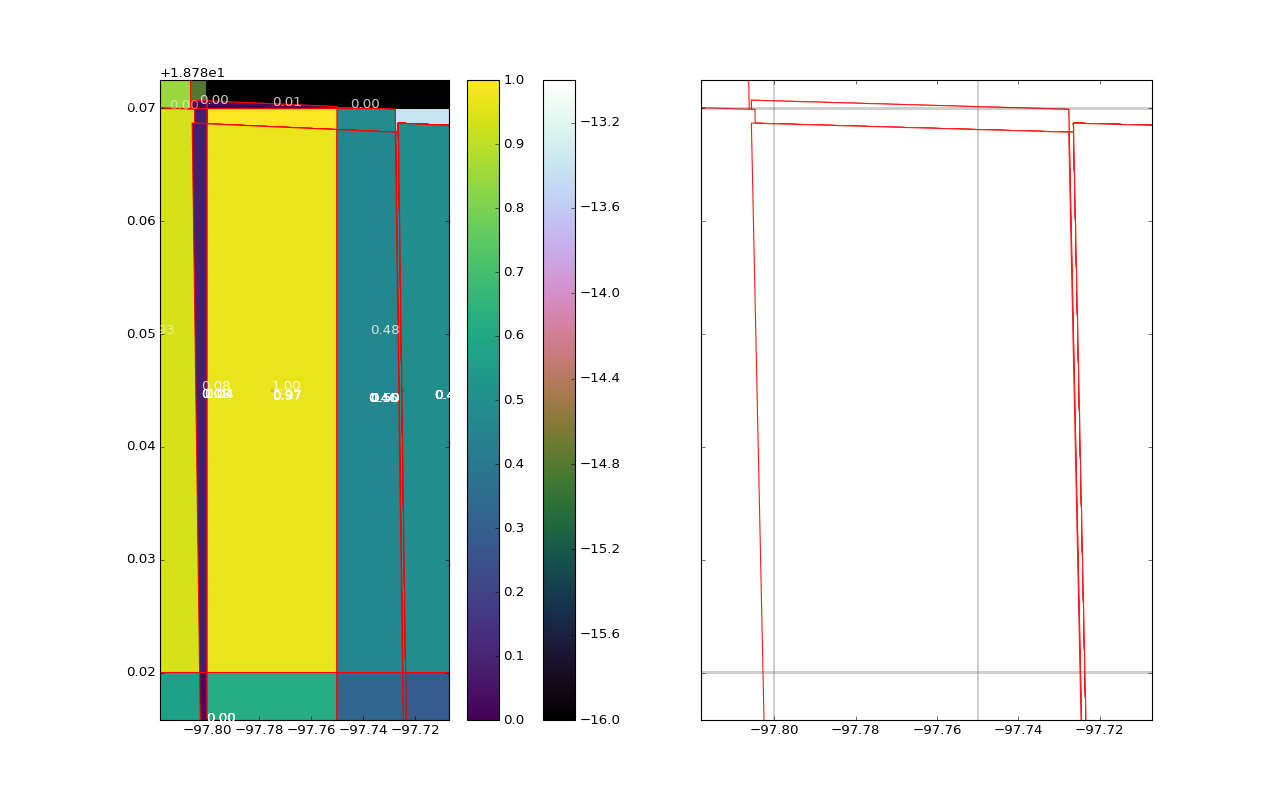

In [17]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig, axs = plt.subplots(1,2, figsize=(16,10), sharex=True, sharey=True)
ax = axs[0]
ax1 = axs[1]

vmin, vmax = rad_min, rad_max


split_rad = split_event_dataset.split_event_energy.data
split_mesh_frac = split_event_dataset.split_event_mesh_area_fraction.data

split_lon = split_event_dataset.split_event_lon
split_lat = split_event_dataset.split_event_lat


# This block is a quick and dirty total event radiance calculation, in the slowest way possible
vals *= 0
# Loop over each sub-quad, using the ctrs 
# for p, area, (x_idx, y_idx), val in good_polys:
#     vals[x_idx, y_idx] += val
mesh_idx = split_event_properties['mesh_idx']
for val, x_idx, y_idx in zip(split_rad, mesh_idx[:,0], mesh_idx[:,1]):
    vals[x_idx, y_idx] += val


# Chopped polys
pm = ax.pcolormesh(X, Y, np.log10(vals), alpha=1.0, edgecolor='none', cmap='cubehelix', vmin=np.log10(vmin), vmax=np.log10(vmax))
ax.plot(mesh.X_ctr, mesh.Y_ctr, '.k', alpha=0.1)
# ax.plot(split_lon, split_lat, '.w', alpha=0.5)
for sln, slt, stx in zip(split_lon.data, split_lat.data, split_mesh_frac):
    ax.text(sln, slt, '{0:3.2f}'.format(stx), color='white', alpha=0.5)

# patches = [Polygon(p, True) for p, area, ctrs, val in good_polys]
patches = [Polygon(p, True) for p in split_event_polys]
# patch_coll = PatchCollection(patches, edgecolors='red', facecolors='none', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
# patch_coll.set_array(split_rad*0)
patch_coll = PatchCollection(patches, edgecolors='red', cmap='viridis', alpha=1.0)
patch_coll.set_array(split_mesh_frac)
patch_coll.set_clim(0, 1)
ax.add_collection(patch_coll)
plt.colorbar(pm, ax=ax)
plt.colorbar(patch_coll, ax=ax)


# Original polys
patches = [Polygon(p, True) for p in event_polys]
patch_coll = PatchCollection(patches, edgecolors='red', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
# patch_coll.set_array(np.fromiter((0 for p in event_polys), dtype=float))
patch_coll.set_array(event_rads)
ax1.add_collection(patch_coll)
pm1 = ax1.pcolormesh(X,Y, vals*0, edgecolor='k', alpha=0.1, norm=pm.norm, cmap=pm.cmap)


# x0, x1, y0, y1 = X.min(), X.max(), Y.min(), Y.max()

# ax.axis((.4,1.5,10,16))
# ax.axis((-93.5,-93,29,30))

In [13]:
for eid in split_event_dataset.event_id:
    print(eid)

<xarray.DataArray 'event_id' ()>
array(2172468314)
Coordinates:
    number_of_events      object (873476972, 2172468314, Timestamp('2017-08-24 23:59:59.848000'), 21.138483462389559, -102.76327395113185) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172468314)
Coordinates:
    number_of_events      object (873476972, 2172468314, Timestamp('2017-08-24 23:59:59.848000'), 21.138483462389559, -102.76327395113185) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172468314)
Coordinates:
    number_of_events      object (873476972, 217

<xarray.DataArray 'event_id' ()>
array(2172471095)
Coordinates:
    number_of_events      object (873477851, 2172471095, Timestamp('2017-08-25 00:00:00.306000'), 22.25771872070618, -104.81080415146425) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172471096)
Coordinates:
    number_of_events      object (873477851, 2172471096, Timestamp('2017-08-25 00:00:00.306000'), 22.259750000666827, -104.89408662985079) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172471096)
Coordinates:
    number_of_events      object (873477851, 2172

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472827)
Coordinates:
    number_of_events      object (873478480, 2172472827, Timestamp('2017-08-25 00:00:01.139000'), 21.926620087120682, -87.91664871876128) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472827)
Coordinates:
    number_of_events      object (873478480, 2172472827, Timestamp('2017-08-25 00:00:01.139000'), 21.926620087120682, -87.91664871876128) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472827)
Coordinates:
    number

<xarray.DataArray 'event_id' ()>
array(2172472857)
Coordinates:
    number_of_events      object (873478488, 2172472857, Timestamp('2017-08-25 00:00:01.143000'), 21.849431448616087, -87.837428800296038) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472857)
Coordinates:
    number_of_events      object (873478488, 2172472857, Timestamp('2017-08-25 00:00:01.143000'), 21.849431448616087, -87.837428800296038) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472857)
Coordinates:
    number_of_events      object (873478488, 217

<xarray.DataArray 'event_id' ()>
array(2172472878)
Coordinates:
    number_of_events      object (873478492, 2172472878, Timestamp('2017-08-25 00:00:01.146000'), 22.003808725625277, -87.837428800296038) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472879)
Coordinates:
    number_of_events      object (873478492, 2172472879, Timestamp('2017-08-25 00:00:01.146000'), 21.926620087120682, -87.837428800296038) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472879)
Coordinates:
    number_of_events      object (873478492, 217

<xarray.DataArray 'event_id' ()>
array(2172472903)
Coordinates:
    number_of_events      object (873478502, 2172472903, Timestamp('2017-08-25 00:00:01.152000'), 21.926620087120682, -87.91664871876128) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472903)
Coordinates:
    number_of_events      object (873478502, 2172472903, Timestamp('2017-08-25 00:00:01.152000'), 21.926620087120682, -87.91664871876128) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472903)
Coordinates:
    number_of_events      object (873478502, 21724

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472963)
Coordinates:
    number_of_events      object (873478522, 2172472963, Timestamp('2017-08-25 00:00:01.168000'), 22.003808725625277, -87.914617438800633) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472973)
Coordinates:
    number_of_events      object (873478526, 2172472973, Timestamp('2017-08-25 00:00:01.169000'), 22.001777445664629, -87.993837357265875) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172472973)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172473019)
Coordinates:
    number_of_events      object (873478547, 2172473019, Timestamp('2017-08-25 00:00:01.186000'), 22.003808725625277, -87.837428800296038) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172473019)
Coordinates:
    number_of_events      object (873478547, 2172473019, Timestamp('2017-08-25 00:00:01.186000'), 22.003808725625277, -87.837428800296038) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172473019)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172473055)
Coordinates:
    number_of_events      object (873478559, 2172473055, Timestamp('2017-08-25 00:00:01.215000'), 22.001777445664629, -87.914617438800633) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172473055)
Coordinates:
    number_of_events      object (873478559, 2172473055, Timestamp('2017-08-25 00:00:01.215000'), 22.001777445664629, -87.914617438800633) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172473055)
Coordinates:
    number_of_events      object (873478559, 217

<xarray.DataArray 'event_id' ()>
array(2172473059)
Coordinates:
    number_of_events      object (873478562, 2172473059, Timestamp('2017-08-25 00:00:01.235000'), 22.798039190238342, -104.6320515149273) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172473059)
Coordinates:
    number_of_events      object (873478562, 2172473059, Timestamp('2017-08-25 00:00:01.235000'), 22.798039190238342, -104.6320515149273) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172473059)
Coordinates:
    number_of_events      object (873478562, 21724

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172477495)
Coordinates:
    number_of_events      object (873479921, 2172477495, Timestamp('2017-08-25 00:00:02.750000'), 22.802101750159636, -104.8859615100082) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172477495)
Coordinates:
    number_of_events      object (873479921, 2172477495, Timestamp('2017-08-25 00:00:02.750000'), 22.802101750159636, -104.8859615100082) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172477495)
Coordinates:
    number

<xarray.DataArray 'event_id' ()>
array(2172478380)
Coordinates:
    number_of_events      object (873480210, 2172478380, Timestamp('2017-08-25 00:00:03.035000'), 22.332876079250127, -104.73564679292031) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172478380)
Coordinates:
    number_of_events      object (873480210, 2172478380, Timestamp('2017-08-25 00:00:03.035000'), 22.332876079250127, -104.73564679292031) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172478380)
Coordinates:
    number_of_events      object (873480210, 217

<xarray.DataArray 'event_id' ()>
array(2172479677)
Coordinates:
    number_of_events      object (873480637, 2172479677, Timestamp('2017-08-25 00:00:03.399000'), 18.07734456169419, -95.6253561694175) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172479677)
Coordinates:
    number_of_events      object (873480637, 2172479677, Timestamp('2017-08-25 00:00:03.399000'), 18.07734456169419, -95.6253561694175) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172479677)
Coordinates:
    number_of_events      object (873480637, 217247967

<xarray.DataArray 'event_id' ()>
array(2172479715)
Coordinates:
    number_of_events      object (873480648, 2172479715, Timestamp('2017-08-25 00:00:03.405000'), 22.7188192717731, -104.70720887347125) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172479715)
Coordinates:
    number_of_events      object (873480648, 2172479715, Timestamp('2017-08-25 00:00:03.405000'), 22.7188192717731, -104.70720887347125) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172479715)
Coordinates:
    number_of_events      object (873480648, 2172479

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172479635)
Coordinates:
    number_of_events      object (873480629, 2172479635, Timestamp('2017-08-25 00:00:03.388000'), 29.535794819705188, -104.86767999036238) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172479635)
Coordinates:
    number_of_events      object (873480629, 2172479635, Timestamp('2017-08-25 00:00:03.388000'), 29.535794819705188, -104.86767999036238) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172479636)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172482434)
Coordinates:
    number_of_events      object (873481458, 2172482434, Timestamp('2017-08-25 00:00:04.027000'), 20.03956100367941, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482434)
Coordinates:
    number_of_events      object (873481458, 2172482434, Timestamp('2017-08-25 00:00:04.027000'), 20.03956100367941, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482435)
Coordinates:
    number_of_events      object (873481459, 21724

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482625)
Coordinates:
    number_of_events      object (873481535, 2172482625, Timestamp('2017-08-25 00:00:04.089000'), 19.960341085214168, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482625)
Coordinates:
    number_of_events      object (873481535, 2172482625, Timestamp('2017-08-25 00:00:04.089000'), 19.960341085214168, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482625)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482837)
Coordinates:
    number_of_events      object (873481609, 2172482837, Timestamp('2017-08-25 00:00:04.183000'), 19.960341085214168, -90.573562907287851) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482837)
Coordinates:
    number_of_events      object (873481609, 2172482837, Timestamp('2017-08-25 00:00:04.183000'), 19.960341085214168, -90.573562907287851) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482837)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172482904)
Coordinates:
    number_of_events      object (873481636, 2172482904, Timestamp('2017-08-25 00:00:04.196000'), 19.960341085214168, -90.573562907287851) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482904)
Coordinates:
    number_of_events      object (873481636, 2172482904, Timestamp('2017-08-25 00:00:04.196000'), 19.960341085214168, -90.573562907287851) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482904)
Coordinates:
    number_of_events      object (873481636, 217

<xarray.DataArray 'event_id' ()>
array(2172482935)
Coordinates:
    number_of_events      object (873481650, 2172482935, Timestamp('2017-08-25 00:00:04.200000'), 20.03956100367941, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482935)
Coordinates:
    number_of_events      object (873481650, 2172482935, Timestamp('2017-08-25 00:00:04.200000'), 20.03956100367941, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482935)
Coordinates:
    number_of_events      object (873481650, 21724

<xarray.DataArray 'event_id' ()>
array(2172483080)
Coordinates:
    number_of_events      object (873481717, 2172483080, Timestamp('2017-08-25 00:00:04.240000'), 20.03956100367941, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172483081)
Coordinates:
    number_of_events      object (873481717, 2172483081, Timestamp('2017-08-25 00:00:04.240000'), 20.120812202105299, -90.575594187248498) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172483081)
Coordinates:
    number_of_events      object (873481717, 2172

<xarray.DataArray 'event_id' ()>
array(2172482462)
Coordinates:
    number_of_events      object (873481473, 2172482462, Timestamp('2017-08-25 00:00:04.042000'), 29.290009944466874, -104.55080031650141) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482462)
Coordinates:
    number_of_events      object (873481473, 2172482462, Timestamp('2017-08-25 00:00:04.042000'), 29.290009944466874, -104.55080031650141) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482462)
Coordinates:
    number_of_events      object (873481473, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482560)
Coordinates:
    number_of_events      object (873481510, 2172482560, Timestamp('2017-08-25 00:00:04.070000'), 29.296103784348816, -104.73158423299901) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482560)
Coordinates:
    number_of_events      object (873481510, 2172482560, Timestamp('2017-08-25 00:00:04.070000'), 29.296103784348816, -104.73158423299901) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482560)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172482782)
Coordinates:
    number_of_events      object (873481591, 2172482782, Timestamp('2017-08-25 00:00:04.154000'), 29.375323702814057, -104.74580319272354) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482782)
Coordinates:
    number_of_events      object (873481591, 2172482782, Timestamp('2017-08-25 00:00:04.154000'), 29.375323702814057, -104.74580319272354) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482782)
Coordinates:
    number_of_events      object (873481591, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482965)
Coordinates:
    number_of_events      object (873481661, 2172482965, Timestamp('2017-08-25 00:00:04.205000'), 20.809416108764708, -102.64545971341431) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482965)
Coordinates:
    number_of_events      object (873481661, 2172482965, Timestamp('2017-08-25 00:00:04.205000'), 20.809416108764708, -102.64545971341431) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172482965)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172484983)
Coordinates:
    number_of_events      object (873482388, 2172484983, Timestamp('2017-08-25 00:00:04.827000'), 21.950995446648449, -104.93471222906373) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172484983)
Coordinates:
    number_of_events      object (873482388, 2172484983, Timestamp('2017-08-25 00:00:04.827000'), 21.950995446648449, -104.93471222906373) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172484906)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172484765)
Coordinates:
    number_of_events      object (873482293, 2172484765, Timestamp('2017-08-25 00:00:04.710000'), 18.729385429061949, -97.681011489592493) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172484765)
Coordinates:
    number_of_events      object (873482293, 2172484765, Timestamp('2017-08-25 00:00:04.710000'), 18.729385429061949, -97.681011489592493) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172484765)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485555)
Coordinates:
    number_of_events      object (873482590, 2172485555, Timestamp('2017-08-25 00:00:05.007000'), 29.39563650242053, -93.340166213689372) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485555)
Coordinates:
    number_of_events      object (873482590, 2172485555, Timestamp('2017-08-25 00:00:05.007000'), 29.39563650242053, -93.340166213689372) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485555)
Coordinates:
    number

<xarray.DataArray 'event_id' ()>
array(2172485309)
Coordinates:
    number_of_events      object (873482492, 2172485309, Timestamp('2017-08-25 00:00:04.868000'), 18.637977830832824, -102.66170995309949) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485309)
Coordinates:
    number_of_events      object (873482492, 2172485309, Timestamp('2017-08-25 00:00:04.868000'), 18.637977830832824, -102.66170995309949) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485309)
Coordinates:
    number_of_events      object (873482492, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485659)
Coordinates:
    number_of_events      object (873482631, 2172485659, Timestamp('2017-08-25 00:00:05.038000'), 29.393605222459882, -93.084224938647822) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485659)
Coordinates:
    number_of_events      object (873482631, 2172485659, Timestamp('2017-08-25 00:00:05.038000'), 29.393605222459882, -93.084224938647822) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485660)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485682)
Coordinates:
    number_of_events      object (873482634, 2172485682, Timestamp('2017-08-25 00:00:05.040000'), 29.39563650242053, -93.169538696995005) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485682)
Coordinates:
    number_of_events      object (873482634, 2172485682, Timestamp('2017-08-25 00:00:05.040000'), 29.39563650242053, -93.169538696995005) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172485683)
Coordinates:
    number

<xarray.DataArray 'event_id' ()>
array(2172487060)
Coordinates:
    number_of_events      object (873483078, 2172487060, Timestamp('2017-08-25 00:00:05.585000'), 22.25771872070618, -104.81080415146425) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172487060)
Coordinates:
    number_of_events      object (873483078, 2172487060, Timestamp('2017-08-25 00:00:05.585000'), 22.25771872070618, -104.81080415146425) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172487060)
Coordinates:
    number_of_events      object (873483078, 21724

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488632)
Coordinates:
    number_of_events      object (873483580, 2172488632, Timestamp('2017-08-25 00:00:06.080000'), 19.560178932966664, -90.492311708861962) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488632)
Coordinates:
    number_of_events      object (873483580, 2172488632, Timestamp('2017-08-25 00:00:06.080000'), 19.560178932966664, -90.492311708861962) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488632)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172488816)
Coordinates:
    number_of_events      object (873483669, 2172488816, Timestamp('2017-08-25 00:00:06.168000'), 19.560178932966664, -90.492311708861962) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488816)
Coordinates:
    number_of_events      object (873483669, 2172488816, Timestamp('2017-08-25 00:00:06.168000'), 19.560178932966664, -90.492311708861962) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488816)
Coordinates:
    number_of_events      object (873483669, 217

<xarray.DataArray 'event_id' ()>
array(2172488866)
Coordinates:
    number_of_events      object (873483688, 2172488866, Timestamp('2017-08-25 00:00:06.178000'), 19.478927734540775, -90.492311708861962) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488866)
Coordinates:
    number_of_events      object (873483688, 2172488866, Timestamp('2017-08-25 00:00:06.178000'), 19.478927734540775, -90.492311708861962) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488866)
Coordinates:
    number_of_events      object (873483688, 217

<xarray.DataArray 'event_id' ()>
array(2172488966)
Coordinates:
    number_of_events      object (873483724, 2172488966, Timestamp('2017-08-25 00:00:06.212000'), 19.480959014501423, -90.569500347366557) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488966)
Coordinates:
    number_of_events      object (873483724, 2172488966, Timestamp('2017-08-25 00:00:06.212000'), 19.480959014501423, -90.569500347366557) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172488966)
Coordinates:
    number_of_events      object (873483724, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489117)
Coordinates:
    number_of_events      object (873483793, 2172489117, Timestamp('2017-08-25 00:00:06.282000'), 19.478927734540775, -90.335903151892126) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489117)
Coordinates:
    number_of_events      object (873483793, 2172489117, Timestamp('2017-08-25 00:00:06.282000'), 19.478927734540775, -90.335903151892126) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489118)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489727)
Coordinates:
    number_of_events      object (873484038, 2172489727, Timestamp('2017-08-25 00:00:06.506000'), 19.208767499774694, -103.28531290101819) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489727)
Coordinates:
    number_of_events      object (873484038, 2172489727, Timestamp('2017-08-25 00:00:06.506000'), 19.208767499774694, -103.28531290101819) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489727)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489163)
Coordinates:
    number_of_events      object (873483809, 2172489163, Timestamp('2017-08-25 00:00:06.307000'), 19.399707816075534, -90.335903151892126) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489163)
Coordinates:
    number_of_events      object (873483809, 2172489163, Timestamp('2017-08-25 00:00:06.307000'), 19.399707816075534, -90.335903151892126) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489164)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172489295)
Coordinates:
    number_of_events      object (873483872, 2172489295, Timestamp('2017-08-25 00:00:06.373000'), 19.399707816075534, -90.41309179039672) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489295)
Coordinates:
    number_of_events      object (873483872, 2172489295, Timestamp('2017-08-25 00:00:06.373000'), 19.399707816075534, -90.41309179039672) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489296)
Coordinates:
    number_of_events      object (873483872, 21724

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489317)
Coordinates:
    number_of_events      object (873483878, 2172489317, Timestamp('2017-08-25 00:00:06.374000'), 19.480959014501423, -90.569500347366557) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489317)
Coordinates:
    number_of_events      object (873483878, 2172489317, Timestamp('2017-08-25 00:00:06.374000'), 19.480959014501423, -90.569500347366557) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172489317)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172490193)
Coordinates:
    number_of_events      object (873484203, 2172490193, Timestamp('2017-08-25 00:00:06.583000'), 21.055200984003022, -102.67186635290273) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172490193)
Coordinates:
    number_of_events      object (873484203, 2172490193, Timestamp('2017-08-25 00:00:06.583000'), 21.055200984003022, -102.67186635290273) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172490193)
Coordinates:
    number_of_events      object (873484203, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172490902)
Coordinates:
    number_of_events      object (873484496, 2172490902, Timestamp('2017-08-25 00:00:06.772000'), 18.729385429061949, -97.681011489592493) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172490902)
Coordinates:
    number_of_events      object (873484496, 2172490902, Timestamp('2017-08-25 00:00:06.772000'), 18.729385429061949, -97.681011489592493) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172490902)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172492326)
Coordinates:
    number_of_events      object (873484988, 2172492326, Timestamp('2017-08-25 00:00:07.505000'), 18.158595760120079, -96.015361921861768) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172492326)
Coordinates:
    number_of_events      object (873484988, 2172492326, Timestamp('2017-08-25 00:00:07.505000'), 18.158595760120079, -96.015361921861768) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172492326)
Coordinates:
    number_of_events      object (873484988, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494015)
Coordinates:
    number_of_events      object (873485474, 2172494015, Timestamp('2017-08-25 00:00:07.849000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494015)
Coordinates:
    number_of_events      object (873485474, 2172494015, Timestamp('2017-08-25 00:00:07.849000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494015)
Coordinates:
    number

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494082)
Coordinates:
    number_of_events      object (873485495, 2172494082, Timestamp('2017-08-25 00:00:07.877000'), 19.082828142214566, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494083)
Coordinates:
    number_of_events      object (873485495, 2172494083, Timestamp('2017-08-25 00:00:07.877000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494083)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172494174)
Coordinates:
    number_of_events      object (873485525, 2172494174, Timestamp('2017-08-25 00:00:07.908000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494174)
Coordinates:
    number_of_events      object (873485525, 2172494174, Timestamp('2017-08-25 00:00:07.908000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494175)
Coordinates:
    number_of_events      object (873485525, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494431)
Coordinates:
    number_of_events      object (873485586, 2172494431, Timestamp('2017-08-25 00:00:07.967000'), 19.082828142214566, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494431)
Coordinates:
    number_of_events      object (873485586, 2172494431, Timestamp('2017-08-25 00:00:07.967000'), 19.082828142214566, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494431)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494501)
Coordinates:
    number_of_events      object (873485604, 2172494501, Timestamp('2017-08-25 00:00:07.984000'), 19.080796862253919, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494502)
Coordinates:
    number_of_events      object (873485604, 2172494502, Timestamp('2017-08-25 00:00:07.984000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494502)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172494523)
Coordinates:
    number_of_events      object (873485610, 2172494523, Timestamp('2017-08-25 00:00:07.993000'), 19.080796862253919, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494523)
Coordinates:
    number_of_events      object (873485610, 2172494523, Timestamp('2017-08-25 00:00:07.993000'), 19.080796862253919, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494523)
Coordinates:
    number_of_events      object (873485610, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494544)
Coordinates:
    number_of_events      object (873485616, 2172494544, Timestamp('2017-08-25 00:00:07.996000'), 19.001576943788677, -90.872161061502993) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494544)
Coordinates:
    number_of_events      object (873485616, 2172494544, Timestamp('2017-08-25 00:00:07.996000'), 19.001576943788677, -90.872161061502993) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494545)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494648)
Coordinates:
    number_of_events      object (873485647, 2172494648, Timestamp('2017-08-25 00:00:08.036000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494648)
Coordinates:
    number_of_events      object (873485647, 2172494648, Timestamp('2017-08-25 00:00:08.036000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494648)
Coordinates:
    number

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494701)
Coordinates:
    number_of_events      object (873485665, 2172494701, Timestamp('2017-08-25 00:00:08.051000'), 19.001576943788677, -90.872161061502993) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494701)
Coordinates:
    number_of_events      object (873485665, 2172494701, Timestamp('2017-08-25 00:00:08.051000'), 19.001576943788677, -90.872161061502993) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494701)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172494777)
Coordinates:
    number_of_events      object (873485691, 2172494777, Timestamp('2017-08-25 00:00:08.069000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494777)
Coordinates:
    number_of_events      object (873485691, 2172494777, Timestamp('2017-08-25 00:00:08.069000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494777)
Coordinates:
    number_of_events      object (873485691, 21724

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494835)
Coordinates:
    number_of_events      object (873485710, 2172494835, Timestamp('2017-08-25 00:00:08.077000'), 19.080796862253919, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494836)
Coordinates:
    number_of_events      object (873485710, 2172494836, Timestamp('2017-08-25 00:00:08.077000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494836)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172494905)
Coordinates:
    number_of_events      object (873485724, 2172494905, Timestamp('2017-08-25 00:00:08.081000'), 19.080796862253919, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494905)
Coordinates:
    number_of_events      object (873485724, 2172494905, Timestamp('2017-08-25 00:00:08.081000'), 19.080796862253919, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494905)
Coordinates:
    number_of_events      object (873485724, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494939)
Coordinates:
    number_of_events      object (873485733, 2172494939, Timestamp('2017-08-25 00:00:08.085000'), 19.082828142214566, -90.951380979968235) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494939)
Coordinates:
    number_of_events      object (873485733, 2172494939, Timestamp('2017-08-25 00:00:08.085000'), 19.082828142214566, -90.951380979968235) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494938)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495210)
Coordinates:
    number_of_events      object (873485825, 2172495210, Timestamp('2017-08-25 00:00:08.147000'), 19.001576943788677, -90.949349700007588) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495210)
Coordinates:
    number_of_events      object (873485825, 2172495210, Timestamp('2017-08-25 00:00:08.147000'), 19.001576943788677, -90.949349700007588) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495210)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172495300)
Coordinates:
    number_of_events      object (873485860, 2172495300, Timestamp('2017-08-25 00:00:08.207000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495301)
Coordinates:
    number_of_events      object (873485861, 2172495301, Timestamp('2017-08-25 00:00:08.208000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495301)
Coordinates:
    number_of_events      object (873485861, 2172

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495385)
Coordinates:
    number_of_events      object (873485886, 2172495385, Timestamp('2017-08-25 00:00:08.238000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495385)
Coordinates:
    number_of_events      object (873485886, 2172495385, Timestamp('2017-08-25 00:00:08.238000'), 19.082828142214566, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495385)
Coordinates:
    number

<xarray.DataArray 'event_id' ()>
array(2172495414)
Coordinates:
    number_of_events      object (873485894, 2172495414, Timestamp('2017-08-25 00:00:08.241000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495414)
Coordinates:
    number_of_events      object (873485894, 2172495414, Timestamp('2017-08-25 00:00:08.241000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495414)
Coordinates:
    number_of_events      object (873485894, 217

<xarray.DataArray 'event_id' ()>
array(2172495429)
Coordinates:
    number_of_events      object (873485897, 2172495429, Timestamp('2017-08-25 00:00:08.242000'), 19.162048060679808, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495429)
Coordinates:
    number_of_events      object (873485897, 2172495429, Timestamp('2017-08-25 00:00:08.242000'), 19.162048060679808, -90.87419234146364) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495429)
Coordinates:
    number_of_events      object (873485897, 21724

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495457)
Coordinates:
    number_of_events      object (873485905, 2172495457, Timestamp('2017-08-25 00:00:08.245000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495457)
Coordinates:
    number_of_events      object (873485905, 2172495457, Timestamp('2017-08-25 00:00:08.245000'), 19.001576943788677, -90.794972422998399) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495457)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495542)
Coordinates:
    number_of_events      object (873485930, 2172495542, Timestamp('2017-08-25 00:00:08.269000'), 19.162048060679808, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495542)
Coordinates:
    number_of_events      object (873485930, 2172495542, Timestamp('2017-08-25 00:00:08.269000'), 19.162048060679808, -90.797003702959046) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495542)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495559)
Coordinates:
    number_of_events      object (873485932, 2172495559, Timestamp('2017-08-25 00:00:08.270000'), 19.001576943788677, -90.949349700007588) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495559)
Coordinates:
    number_of_events      object (873485932, 2172495559, Timestamp('2017-08-25 00:00:08.270000'), 19.001576943788677, -90.949349700007588) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172495559)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494650)
Coordinates:
    number_of_events      object (873485649, 2172494650, Timestamp('2017-08-25 00:00:08.038000'), 29.454543621279299, -104.76205343240872) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494650)
Coordinates:
    number_of_events      object (873485649, 2172494650, Timestamp('2017-08-25 00:00:08.038000'), 29.454543621279299, -104.76205343240872) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172494650)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172496792)
Coordinates:
    number_of_events      object (873486345, 2172496792, Timestamp('2017-08-25 00:00:08.630000'), 22.103341443696991, -104.78846007189713) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172496792)
Coordinates:
    number_of_events      object (873486345, 2172496792, Timestamp('2017-08-25 00:00:08.630000'), 22.103341443696991, -104.78846007189713) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172496793)
Coordinates:
    number_of_events      object (873486345, 217

<xarray.DataArray 'event_id' ()>
array(2172496944)
Coordinates:
    number_of_events      object (873486397, 2172496944, Timestamp('2017-08-25 00:00:08.669000'), 22.103341443696991, -104.78846007189713) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172496944)
Coordinates:
    number_of_events      object (873486397, 2172496944, Timestamp('2017-08-25 00:00:08.669000'), 22.103341443696991, -104.78846007189713) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172496945)
Coordinates:
    number_of_events      object (873486397, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497120)
Coordinates:
    number_of_events      object (873486485, 2172497120, Timestamp('2017-08-25 00:00:08.945000'), 22.958510307129472, -104.90830558957532) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497120)
Coordinates:
    number_of_events      object (873486485, 2172497120, Timestamp('2017-08-25 00:00:08.945000'), 22.958510307129472, -104.90830558957532) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497120)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497381)
Coordinates:
    number_of_events      object (873486577, 2172497381, Timestamp('2017-08-25 00:00:09.054000'), 22.956479027168825, -104.82299183122814) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497381)
Coordinates:
    number_of_events      object (873486577, 2172497381, Timestamp('2017-08-25 00:00:09.054000'), 22.956479027168825, -104.82299183122814) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497381)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497981)
Coordinates:
    number_of_events      object (873486764, 2172497981, Timestamp('2017-08-25 00:00:09.200000'), 19.960341085214168, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497981)
Coordinates:
    number_of_events      object (873486764, 2172497981, Timestamp('2017-08-25 00:00:09.200000'), 19.960341085214168, -90.496374268783256) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172497981)
Coordinates:
    numb

<xarray.DataArray 'event_id' ()>
array(2172498335)
Coordinates:
    number_of_events      object (873486930, 2172498335, Timestamp('2017-08-25 00:00:09.464000'), 22.716787991812453, -104.62189511512406) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172498335)
Coordinates:
    number_of_events      object (873486930, 2172498335, Timestamp('2017-08-25 00:00:09.464000'), 22.716787991812453, -104.62189511512406) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172498335)
Coordinates:
    number_of_events      object (873486930, 217

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172498680)
Coordinates:
    number_of_events      object (873487046, 2172498680, Timestamp('2017-08-25 00:00:09.519000'), 22.716787991812453, -104.53658135677688) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172498680)
Coordinates:
    number_of_events      object (873487046, 2172498680, Timestamp('2017-08-25 00:00:09.519000'), 22.716787991812453, -104.53658135677688) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172498680)
Coordinates:
    numb

    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172500367)
Coordinates:
    number_of_events      object (873487666, 2172500367, Timestamp('2017-08-25 00:00:10.004000'), 21.138483462389559, -102.84452514955774) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172500367)
Coordinates:
    number_of_events      object (873487666, 2172500367, Timestamp('2017-08-25 00:00:10.004000'), 21.138483462389559, -102.84452514955774) ...
    product_time          datetime64[ns] ...
    lightning_wavelength  float32 ...
    group_time_threshold  float32 ...
    flash_time_threshold  float32 ...
    lat_field_of_view     float32 ...
    lon_field_of_view     float32 -89.5
<xarray.DataArray 'event_id' ()>
array(2172500367)
Coordinates:
    numb

In [15]:
ax.text?